In [251]:
import pandas as pd
import os

# DATASET FROM: http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

# GF TODO: check if excel present, otherwise download it
# wget http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

excel_with_path  = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.xlsx'
pickle_with_path = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.pkl'
csv_with_path = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.csv'

df = None

if os.path.isfile(pickle_with_path):
    print('-> picke already exists, much faster using it than opening excel files\n')
    df = pd.read_pickle(pickle_with_path)
else:
    print('-> picke does not exist, go to excel, and create it\n')
    df1 = pd.read_excel (excel_with_path,'Year 2009-2010')
    df2 = pd.read_excel (excel_with_path,'Year 2010-2011')
    df = pd.concat([df1, df2])
    df.to_pickle(pickle_with_path)

-> picke already exists, much faster using it than opening excel files



In [252]:
# define transaction: total cash for a single 'row' of the dataset, i.e. item_price times the number of items bought
df['Transaction'] = df.Quantity * df.Price
df=df.rename(columns={"Customer ID": "Customer_ID"})

# day, week and time are added for convenience of analysis later on
from datetime import datetime
df['InvoiceDay'] = df['InvoiceDate'].map(lambda p: p.date())
df['InvoiceTime'] = df['InvoiceDate'].map(lambda p: p.time())
df['InvoiceWeek'] = df['InvoiceDate'].map(lambda p: p.isocalendar()[1]+52*(p.year-2010))

# avoide negative weeks and start counting from the first week of the dataset, which starts from 01/12/2009
df['InvoiceWeek'] = df['InvoiceWeek']+3


# implement the definition of cancellation in the documentation:
# http://archive.ics.uci.edu/ml/datasets/Online+Retail+II
#      ==> "If this code starts with the letter 'c', it indicates a cancellation.""
def is_cancellation(s):
    if isinstance(s, int):
        #print "ordinary invoice"
        return 0
    elif isinstance(s, unicode):
        #print "unicode string"
        if s.rfind('C')!=-1:
            return 1
        else:
            # print "Something unexpected"  # found, e.g. A506401
            # print s
            return 2
df['IsCancellation'] = df['Invoice'].map(is_cancellation)     
      


# items with prices above ~1500 are so few that is worth looking at them in detail, and excluding them from the plots
# There'a lot of transactions with price set to 0, which based on the descriptions are 
max_item_price=1400
r             =(0,max_item_price)
def is_ordinary_item(p):
    if abs(p)>max_item_price or p==0:
        return 0
    else:
        return 1
df['IsOrdinaryItem'] = df['Price'].map(is_ordinary_item)        

# df.to_csv(csv_with_path, encoding = 'utf-8')

In [253]:
df.dtypes

Invoice                   object
StockCode                 object
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
Price                    float64
Customer_ID              float64
Country                   object
Transaction              float64
InvoiceDay                object
InvoiceTime               object
InvoiceWeek                int64
IsCancellation             int64
IsOrdinaryItem             int64
dtype: object

In [254]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01,07:45:00,0,0,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,07:45:00,0,0,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,07:45:00,0,0,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01,07:45:00,0,0,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01,07:45:00,0,0,1


In [255]:
# what are the nulls in each feature?
nulls = df.isnull().sum()[df.isnull().sum() != 0]

# select all transactions containing 
df_nulls = df[df.isnull().any(axis=1)].copy(deep=True)

nulls_rel = nulls/df.shape[0]*100

nulls_summary = pd.concat([nulls, nulls_rel], axis=1, keys=['nulls', 'rel. nulls [%]'])\
               .sort_values('nulls', ascending=False)

nulls_summary

,nulls,rel. nulls [%]
Customer_ID,243007,22.766873
Description,4382,0.410541


In [256]:
# df_nulls

In [257]:
# NEARLY all cancellations have either Quantity or Price set to negative values
# there are only two exceptions, here below:
#           one of which is an actual cancellation
#           the second of which is an onforeseen transaction type which starts with A
(df.loc[ (df.IsCancellation > 0.) & (df.Transaction > 0.) ])

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom,373.57,2010-02-01,08:24:00,8,1,1
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,11062.06,2011-08-12,14:50:00,87,2,0


In [258]:
# there are 6 data entries which are neither normal transactions nor cancellations which are neither 
# they're described as "Adjust bad debt"
(df.loc[ (df.IsCancellation == 2) ])

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom,-53594.36,2010-04-29,13:36:00,20,2,0
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom,-44031.79,2010-07-19,11:24:00,32,2,0
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom,-38925.87,2010-10-20,12:04:00,45,2,0
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,11062.06,2011-08-12,14:50:00,87,2,0
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,-11062.06,2011-08-12,14:51:00,87,2,0
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,-11062.06,2011-08-12,14:52:00,87,2,0


In [259]:
# remove the "Adjust bad debt"
df = (df.loc[ (df.IsCancellation < 2) ])

#from IPython.core.display import display, HTML
#display(HTML("""<a href="https://google.at">text</a>"""))

#<a id='the_destination'></a>

## todo
- nan and empty -> cleanup   # IN THE MAKING -> only consequences on the users study
- add colums for data and time, separately ?    # DONE
- create a second DF by user: RFM added to


## What do I want to extract from this dataset?
- https://en.wikipedia.org/wiki/Exploratory_data_analysis

- how many customers   DONE
- make a pliot of transaction, of purchase prices, and of invoice_price! #  DONE

- VS TIME: trends of spending overall, by country
- revenue as a function of date, as a function of the time in the day  # DONE
- trends of spending: overall, by the largest customer, by the smaller customers (TOO SPECIFIC?)

- NEED TO BUILD A PER CUSTOMER DF
- customer: how many transactions, how much total revenue:
    => BREAK DOWN BY country, tra
- RMF


- ==> do this
- how many different types of items
- what kind of items are bought the most (by NUMBER of by REVENUE), are cancelled the most, 
- how much revenue per type of item bought

- correlation between
- cancellations: fraction of cancellation by nunber of transactions and by proportion of renenue
-                correlation to CHURNING ? Correlation to country OR type of good purchased ?

- cust.groupby('customer_unique_id').size().value_counts() => The majority of customers made only a single purchase. # DONE


- Can I cathegorise the purchasable items? => If so, customers split across those cathegories
- Persona; how many cheap items, few expensive ones?
- https://cxl.com/blog/creating-customer-personas-using-data-driven-research/
- now many items are bought per session, how much is spent per session

==> TOWARDS CUSTOMER PERSONA DEFINITION
- MANY TRANSACTIONS ARE RECORDED AT THE SAME TIME => as if they were a single shopping session, but billed in split goups of goods
- the function summary_data_from_transaction_data treats transactions taking place on the same day as A SINGLE ONE!

---
<a id="section_ID_GF"></a>

- this section can be reached at this URL https://swan001.cern.ch/user/franzoni/notebooks/SWAN_projects/proton/proton-EDA.ipynb#section_ID_GF
- thanks to this documentation

<a id="section_single_items"></a>
## SINGLE ITEM PRICE AND single item purchases
- how many single items are there (ordinary transaction) # DONE
- what is the cost of each single item
- what is the purchase frequency of each item

- what is the resulting price distribution for all transactions

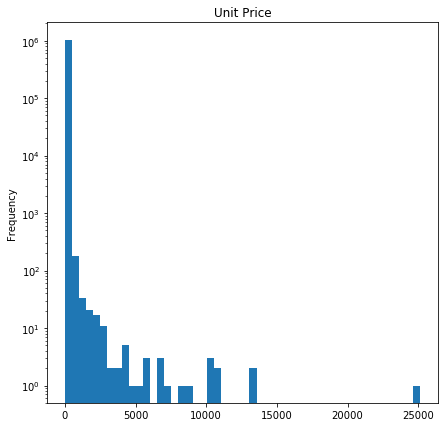

In [260]:
# Exclude cancellations to get the spectrum of single items price
# motivation: the cancellation would give rise to a double counting

# NOTE: cancellations are sometimes negative Quantity for positive price,
# other times they are positive Quantity and negative price
tit='Unit Price'
#(df.loc[ (df.Price > 0.) & (df.Quantity > 0)]).Price.plot(kind='hist',logy=True,title=tit,bins=50,figsize=(7,7))
(df.loc[ (df.IsCancellation ==0 ) ]).Price.plot(kind='hist',logy=True,title=tit,bins=50,figsize=(7,7))

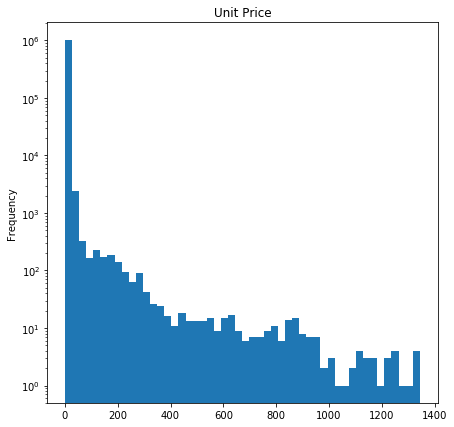

In [261]:
(df.loc[ (df.IsCancellation ==0 ) & (df['IsOrdinaryItem']==1)]).Price.plot(kind='hist',logy=True,title=tit,bins=50,figsize=(7,7))

In [304]:
fraction_non_ordinary=100.*len(df.loc[  (df['IsOrdinaryItem']!=1)]) / len( (df.loc[  (df['IsOrdinaryItem']==1)])   )
print('%f percent of the total items are non ordinary, defined as above %d or zero'%(fraction_non_ordinary,max_item_price))

0.601802 percent of the total items are non ordinary, defined as above 1400 or zero


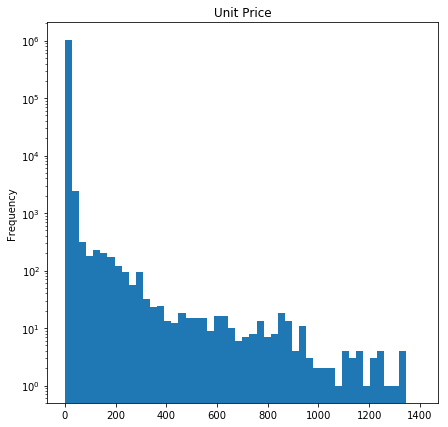

In [262]:
(df.loc[ (df.IsCancellation ==0 ) ]).Price.plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

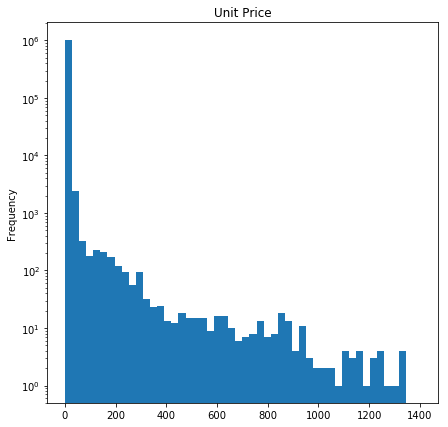

In [263]:
(df.loc[ (df.IsCancellation ==0 ) & (df['IsOrdinaryItem']==1) ]).Price.plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

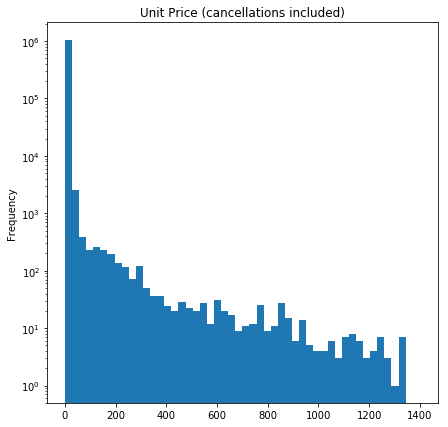

In [264]:
# alternative logic: account for cancelled items, as if they were normal purchases
tit='Unit Price (cancellations included)'
df['Price'].map(lambda p: abs(p)) \
           .plot(kind='hist',logy=True,title=tit,bins=50,range=r,figsize=(7,7))

In [265]:
# What are the transactions-or-cancellations above max_item_price
# see them all
# df.loc[ (df.Price > max_item_price) | (df.Price < -1*max_item_price) ].head(20000)

# group them by Description to see what they are and how many 
df.loc[ df.IsOrdinaryItem==0 ].groupby('Description').Description.agg([len]) \
              .rename(columns={"len": "item_huge_price"})            \
              .sort_values(by=['item_huge_price'],ascending=False)


# All prices/cancellatons in excess of 1500 are 'special accounting actions',
# and are not actual goods being purchased

,item_huge_price
Description,
check,162
Manual,130
?,92
damages,84
damaged,81
AMAZON FEE,39
found,28
missing,27
DOTCOM POSTAGE,21


In [266]:
# how many ORDINARY items are on the cathalogue, based on unique description and price not set to 0
len(df.loc[ df.IsOrdinaryItem==1 ].Description.unique())

5414

In [305]:
# transactions with 0 prices --> all have odd/dodgy descriptions: manipulation errors and the like
df.loc[ (df.IsOrdinaryItem==1) & (df.Price==0)]
len(df.loc[ (df.IsOrdinaryItem==1) & (df.Price==0)])
# this is 0 by construction, since IsOrdinaryItem flips to 0 of Price==0

0

In [335]:
print('Several ordinary items are sold at different prieces; what fraction have different prices and what fraction has identical price?')

def is_price_unique(row):
    if row.min>=row.max and row.min<=row.max:
        row.price_unique=100 
        print('')

        print(row.min)
        print(row.max)
        print(row)
        print('--> the same')
    else:
        row.price_unique=999
        print('')
        print('')
        print(row.min)
        print(row.max)
        print(row)
        print('--> NOT the same')
    return row
# https://stackoverflow.com/questions/27474921/compare-two-columns-using-pandas
a = df.loc[ df.IsOrdinaryItem==1 ].groupby('Description').Price.agg([len,min,max,sum]) \
                                  .sort_values(by=['sum'],ascending=False)             \

b=a.apply(is_price_unique, axis='columns')
b
# TO DO: make a spectrum of the price for each element in the cathalogue

Several ordinary items are sold at different prieces; what fraction have different prices and what fraction has identical price?


<bound method Series.min of len      1423.00
min         0.35
max      1325.00
sum    291471.72
Name: DOTCOM POSTAGE, dtype: float64>
<bound method Series.max of len      1423.00
min         0.35
max      1325.00
sum    291471.72
Name: DOTCOM POSTAGE, dtype: float64>
len      1423.00
min         0.35
max      1325.00
sum    291471.72
Name: DOTCOM POSTAGE, dtype: float64
--> NOT the same


<bound method Series.min of len      1423.00
min         0.35
max      1325.00
sum    291471.72
Name: DOTCOM POSTAGE, dtype: float64>
<bound method Series.max of len      1423.00
min         0.35
max      1325.00
sum    291471.72
Name: DOTCOM POSTAGE, dtype: float64>
len      1423.00
min         0.35
max      1325.00
sum    291471.72
Name: DOTCOM POSTAGE, dtype: float64
--> NOT the same


<bound method Series.min of len      1296.00
min         0.03
max      1343.44
sum   

<bound method Series.max of len    1015.00
min       1.95
max      13.00
sum    6915.63
Name: EDWARDIAN PARASOL BLACK, dtype: float64>
len    1015.00
min       1.95
max      13.00
sum    6915.63
Name: EDWARDIAN PARASOL BLACK, dtype: float64
--> NOT the same


<bound method Series.min of len     745.00
min       4.58
max      16.98
sum    6879.14
Name: DOORMAT FANCY FONT HOME SWEET HOME, dtype: float64>
<bound method Series.max of len     745.00
min       4.58
max      16.98
sum    6879.14
Name: DOORMAT FANCY FONT HOME SWEET HOME, dtype: float64>
len     745.00
min       4.58
max      16.98
sum    6879.14
Name: DOORMAT FANCY FONT HOME SWEET HOME, dtype: float64
--> NOT the same


<bound method Series.min of len    2107.00
min       1.90
max       6.95
sum    6766.47
Name: HEART OF WICKER LARGE, dtype: float64>
<bound method Series.max of len    2107.00
min       1.90
max       6.95
sum    6766.47
Name: HEART OF WICKER LARGE, dtype: float64>
len    2107.00
min       1.90
max       6.95
s

--> NOT the same


<bound method Series.min of len     906.00
min       3.67
max      11.95
sum    5654.51
Name: NATURAL SLATE CHALKBOARD LARGE , dtype: float64>
<bound method Series.max of len     906.00
min       3.67
max      11.95
sum    5654.51
Name: NATURAL SLATE CHALKBOARD LARGE , dtype: float64>
len     906.00
min       3.67
max      11.95
sum    5654.51
Name: NATURAL SLATE CHALKBOARD LARGE , dtype: float64
--> NOT the same


<bound method Series.min of len    1029.00
min       4.25
max      12.21
sum    5651.45
Name: RETROSPOT HEART HOT WATER BOTTLE, dtype: float64>
<bound method Series.max of len    1029.00
min       4.25
max      12.21
sum    5651.45
Name: RETROSPOT HEART HOT WATER BOTTLE, dtype: float64>
len    1029.00
min       4.25
max      12.21
sum    5651.45
Name: RETROSPOT HEART HOT WATER BOTTLE, dtype: float64
--> NOT the same


<bound method Series.min of len    2296.00
min       1.65
max       5.06
sum    5595.71
Name: JUMBO SHOPPER VINTAGE RED PAISLEY, dtype: floa

Name: JUMBO  BAG BAROQUE BLACK WHITE, dtype: float64>
len    1962.00
min       1.65
max       5.06
sum    4735.33
Name: JUMBO  BAG BAROQUE BLACK WHITE, dtype: float64
--> NOT the same


<bound method Series.min of len     540.00
min       7.65
max      16.98
sum    4734.25
Name: IVORY DINER WALL CLOCK, dtype: float64>
<bound method Series.max of len     540.00
min       7.65
max      16.98
sum    4734.25
Name: IVORY DINER WALL CLOCK, dtype: float64>
len     540.00
min       7.65
max      16.98
sum    4734.25
Name: IVORY DINER WALL CLOCK, dtype: float64
--> NOT the same


<bound method Series.min of len     537.00
min       6.68
max      20.15
sum    4713.63
Name: CHILDS BREAKFAST SET CIRCUS PARADE, dtype: float64>
<bound method Series.max of len     537.00
min       6.68
max      20.15
sum    4713.63
Name: CHILDS BREAKFAST SET CIRCUS PARADE, dtype: float64>
len     537.00
min       6.68
max      20.15
sum    4713.63
Name: CHILDS BREAKFAST SET CIRCUS PARADE, dtype: float64
--> NOT the s

--> NOT the same


<bound method Series.min of len     869.00
min       3.39
max       7.78
sum    4001.08
Name: BINGO SET, dtype: float64>
<bound method Series.max of len     869.00
min       3.39
max       7.78
sum    4001.08
Name: BINGO SET, dtype: float64>
len     869.00
min       3.39
max       7.78
sum    4001.08
Name: BINGO SET, dtype: float64
--> NOT the same


<bound method Series.min of len    1236.00
min       2.55
max       6.95
sum    3939.70
Name: ROUND SNACK BOXES SET OF 4 FRUITS , dtype: float64>
<bound method Series.max of len    1236.00
min       2.55
max       6.95
sum    3939.70
Name: ROUND SNACK BOXES SET OF 4 FRUITS , dtype: float64>
len    1236.00
min       2.55
max       6.95
sum    3939.70
Name: ROUND SNACK BOXES SET OF 4 FRUITS , dtype: float64
--> NOT the same


<bound method Series.min of len     733.00
min       3.75
max      12.72
sum    3923.09
Name: AIRLINE BAG VINTAGE TOKYO 78, dtype: float64>
<bound method Series.max of len     733.00
min       3.75
ma

<bound method Series.min of len    1257.00
min       1.49
max       8.33
sum    3457.24
Name: HOT BATHS METAL SIGN, dtype: float64>
<bound method Series.max of len    1257.00
min       1.49
max       8.33
sum    3457.24
Name: HOT BATHS METAL SIGN, dtype: float64>
len    1257.00
min       1.49
max       8.33
sum    3457.24
Name: HOT BATHS METAL SIGN, dtype: float64
--> NOT the same


<bound method Series.min of len     445.00
min       1.95
max      14.74
sum    3445.88
Name: ROSE CARAVAN DOORSTOP, dtype: float64>
<bound method Series.max of len     445.00
min       1.95
max      14.74
sum    3445.88
Name: ROSE CARAVAN DOORSTOP, dtype: float64>
len     445.00
min       1.95
max      14.74
sum    3445.88
Name: ROSE CARAVAN DOORSTOP, dtype: float64
--> NOT the same


<bound method Series.min of len     600.00
min       3.96
max      10.17
sum    3444.58
Name: RED RETROSPOT BUTTER DISH, dtype: float64>
<bound method Series.max of len     600.00
min       3.96
max      10.17
sum    3444.58


len     921.00
min       1.49
max       5.91
sum    3045.91
Name: METAL SIGN TAKE IT OR LEAVE IT , dtype: float64
--> NOT the same


<bound method Series.min of len    1934.00
min       0.90
max      14.75
sum    3038.66
Name: VICTORIAN GLASS HANGING T-LIGHT, dtype: float64>
<bound method Series.max of len    1934.00
min       0.90
max      14.75
sum    3038.66
Name: VICTORIAN GLASS HANGING T-LIGHT, dtype: float64>
len    1934.00
min       0.90
max      14.75
sum    3038.66
Name: VICTORIAN GLASS HANGING T-LIGHT, dtype: float64
--> NOT the same


<bound method Series.min of len     744.00
min       3.39
max       8.95
sum    3028.35
Name: FELTCRAFT PRINCESS CHARLOTTE DOLL, dtype: float64>
<bound method Series.max of len     744.00
min       3.39
max       8.95
sum    3028.35
Name: FELTCRAFT PRINCESS CHARLOTTE DOLL, dtype: float64>
len     744.00
min       3.39
max       8.95
sum    3028.35
Name: FELTCRAFT PRINCESS CHARLOTTE DOLL, dtype: float64
--> NOT the same


<bound method Series.mi

<bound method Series.min of len     401.00
min       3.00
max      13.00
sum    2747.48
Name: EDWARDIAN PARASOL PINK, dtype: float64>
<bound method Series.max of len     401.00
min       3.00
max      13.00
sum    2747.48
Name: EDWARDIAN PARASOL PINK, dtype: float64>
len     401.00
min       3.00
max      13.00
sum    2747.48
Name: EDWARDIAN PARASOL PINK, dtype: float64
--> NOT the same


<bound method Series.min of len     644.00
min       2.66
max       7.78
sum    2745.70
Name: RED FLORAL FELTCRAFT SHOULDER BAG, dtype: float64>
<bound method Series.max of len     644.00
min       2.66
max       7.78
sum    2745.70
Name: RED FLORAL FELTCRAFT SHOULDER BAG, dtype: float64>
len     644.00
min       2.66
max       7.78
sum    2745.70
Name: RED FLORAL FELTCRAFT SHOULDER BAG, dtype: float64
--> NOT the same


<bound method Series.min of len     122.00
min      12.75
max      30.43
sum    2742.72
Name: ELEPHANT CARNIVAL POUFFE, dtype: float64>
<bound method Series.max of len     122.00
min 

<bound method Series.max of len     265.00
min       4.58
max      15.79
sum    2461.62
Name: DOORMAT MULTICOLOUR STRIPE, dtype: float64>
len     265.00
min       4.58
max      15.79
sum    2461.62
Name: DOORMAT MULTICOLOUR STRIPE, dtype: float64
--> NOT the same


<bound method Series.min of len     490.00
min       2.66
max       8.65
sum    2459.19
Name: SET3 BOOK BOX GREEN GINGHAM FLOWER , dtype: float64>
<bound method Series.max of len     490.00
min       2.66
max       8.65
sum    2459.19
Name: SET3 BOOK BOX GREEN GINGHAM FLOWER , dtype: float64>
len     490.00
min       2.66
max       8.65
sum    2459.19
Name: SET3 BOOK BOX GREEN GINGHAM FLOWER , dtype: float64
--> NOT the same


<bound method Series.min of len     747.00
min       2.00
max       6.04
sum    2449.50
Name: HOME SWEET HOME METAL SIGN , dtype: float64>
<bound method Series.max of len     747.00
min       2.00
max       6.04
sum    2449.50
Name: HOME SWEET HOME METAL SIGN , dtype: float64>
len     747.00
min       

len     594.00
min       1.98
max       6.04
sum    2210.84
Name: S/6 WOODEN SKITTLES IN COTTON BAG, dtype: float64
--> NOT the same


<bound method Series.min of len     431.00
min       3.75
max      13.13
sum    2202.85
Name: CHILDRENS CUTLERY POLKADOT PINK, dtype: float64>
<bound method Series.max of len     431.00
min       3.75
max      13.13
sum    2202.85
Name: CHILDRENS CUTLERY POLKADOT PINK, dtype: float64>
len     431.00
min       3.75
max      13.13
sum    2202.85
Name: CHILDRENS CUTLERY POLKADOT PINK, dtype: float64
--> NOT the same


<bound method Series.min of len     290.00
min       4.00
max      13.87
sum    2199.09
Name: DAIRY MAID TRADITIONAL TEAPOT , dtype: float64>
<bound method Series.max of len     290.00
min       4.00
max      13.87
sum    2199.09
Name: DAIRY MAID TRADITIONAL TEAPOT , dtype: float64>
len     290.00
min       4.00
max      13.87
sum    2199.09
Name: DAIRY MAID TRADITIONAL TEAPOT , dtype: float64
--> NOT the same


<bound method Series.min of le


<bound method Series.min of len     661.00
min       2.10
max       5.91
sum    1976.88
Name: PIGGY BANK RETROSPOT , dtype: float64>
<bound method Series.max of len     661.00
min       2.10
max       5.91
sum    1976.88
Name: PIGGY BANK RETROSPOT , dtype: float64>
len     661.00
min       2.10
max       5.91
sum    1976.88
Name: PIGGY BANK RETROSPOT , dtype: float64
--> NOT the same


<bound method Series.min of len     449.00
min       2.62
max       7.62
sum    1976.62
Name: HOLIDAY FUN LUDO, dtype: float64>
<bound method Series.max of len     449.00
min       2.62
max       7.62
sum    1976.62
Name: HOLIDAY FUN LUDO, dtype: float64>
len     449.00
min       2.62
max       7.62
sum    1976.62
Name: HOLIDAY FUN LUDO, dtype: float64
--> NOT the same


<bound method Series.min of len     838.00
min       1.69
max       4.30
sum    1975.20
Name: AREA PATROLLED METAL SIGN, dtype: float64>
<bound method Series.max of len     838.00
min       1.69
max       4.30
sum    1975.20
Name: AREA 

<bound method Series.min of len     937.00
min       1.18
max       4.13
sum    1816.10
Name: GARDENERS KNEELING PAD KEEP CALM , dtype: float64>
<bound method Series.max of len     937.00
min       1.18
max       4.13
sum    1816.10
Name: GARDENERS KNEELING PAD KEEP CALM , dtype: float64>
len     937.00
min       1.18
max       4.13
sum    1816.10
Name: GARDENERS KNEELING PAD KEEP CALM , dtype: float64
--> NOT the same


<bound method Series.min of len     190.00
min       7.65
max      17.35
sum    1815.75
Name: METAL SHELF WITH RAIL , dtype: float64>
<bound method Series.max of len     190.00
min       7.65
max      17.35
sum    1815.75
Name: METAL SHELF WITH RAIL , dtype: float64>
len     190.00
min       7.65
max      17.35
sum    1815.75
Name: METAL SHELF WITH RAIL , dtype: float64
--> NOT the same


<bound method Series.min of len     422.00
min       1.25
max       7.62
sum    1815.55
Name: RED RETROSPOT TEA CUP AND SAUCER , dtype: float64>
<bound method Series.max of len     42

<bound method Series.max of len     304.00
min       3.95
max      13.57
sum    1676.65
Name: AIRLINE BAG VINTAGE JET SET BROWN, dtype: float64>
len     304.00
min       3.95
max      13.57
sum    1676.65
Name: AIRLINE BAG VINTAGE JET SET BROWN, dtype: float64
--> NOT the same


<bound method Series.min of len     188.00
min       7.45
max      16.63
sum    1675.90
Name: RECYCLED ACAPULCO MAT RED, dtype: float64>
<bound method Series.max of len     188.00
min       7.45
max      16.63
sum    1675.90
Name: RECYCLED ACAPULCO MAT RED, dtype: float64>
len     188.00
min       7.45
max      16.63
sum    1675.90
Name: RECYCLED ACAPULCO MAT RED, dtype: float64
--> NOT the same


<bound method Series.min of len     269.00
min       1.95
max      11.02
sum    1675.68
Name: SPACEBOY TV DINNER TRAY, dtype: float64>
<bound method Series.max of len     269.00
min       1.95
max      11.02
sum    1675.68
Name: SPACEBOY TV DINNER TRAY, dtype: float64>
len     269.00
min       1.95
max      11.02
sum 

<bound method Series.max of len     337.00
min       3.75
max       8.29
sum    1577.79
Name: CLASSIC GLASS COOKIE JAR, dtype: float64>
len     337.00
min       3.75
max       8.29
sum    1577.79
Name: CLASSIC GLASS COOKIE JAR, dtype: float64
--> NOT the same


<bound method Series.min of len     164.00
min       7.45
max      16.63
sum    1577.66
Name: RECYCLED ACAPULCO MAT BLUE, dtype: float64>
<bound method Series.max of len     164.00
min       7.45
max      16.63
sum    1577.66
Name: RECYCLED ACAPULCO MAT BLUE, dtype: float64>
len     164.00
min       7.45
max      16.63
sum    1577.66
Name: RECYCLED ACAPULCO MAT BLUE, dtype: float64
--> NOT the same


<bound method Series.min of len     460.00
min       2.55
max       6.95
sum    1577.03
Name: TOADSTOOL MONEY BOX, dtype: float64>
<bound method Series.max of len     460.00
min       2.55
max       6.95
sum    1577.03
Name: TOADSTOOL MONEY BOX, dtype: float64>
len     460.00
min       2.55
max       6.95
sum    1577.03
Name: TOADST

<bound method Series.min of len     384.00
min       2.55
max       6.95
sum    1475.05
Name: GLASS JAR DIGESTIVE BISCUITS, dtype: float64>
<bound method Series.max of len     384.00
min       2.55
max       6.95
sum    1475.05
Name: GLASS JAR DIGESTIVE BISCUITS, dtype: float64>
len     384.00
min       2.55
max       6.95
sum    1475.05
Name: GLASS JAR DIGESTIVE BISCUITS, dtype: float64
--> NOT the same


<bound method Series.min of len    1015.00
min       1.06
max       6.04
sum    1473.86
Name: BLUE HARMONICA IN BOX , dtype: float64>
<bound method Series.max of len    1015.00
min       1.06
max       6.04
sum    1473.86
Name: BLUE HARMONICA IN BOX , dtype: float64>
len    1015.00
min       1.06
max       6.04
sum    1473.86
Name: BLUE HARMONICA IN BOX , dtype: float64
--> NOT the same


<bound method Series.min of len     608.00
min       1.65
max       4.13
sum    1473.51
Name: JUMBO BAG PEARS, dtype: float64>
<bound method Series.max of len     608.00
min       1.65
max       4.1

<bound method Series.min of len     296.00
min       3.39
max       8.47
sum    1366.58
Name: CHERRY BLOSSOM  DECORATIVE FLASK, dtype: float64>
<bound method Series.max of len     296.00
min       3.39
max       8.47
sum    1366.58
Name: CHERRY BLOSSOM  DECORATIVE FLASK, dtype: float64>
len     296.00
min       3.39
max       8.47
sum    1366.58
Name: CHERRY BLOSSOM  DECORATIVE FLASK, dtype: float64
--> NOT the same


<bound method Series.min of len     249.00
min       3.39
max       8.29
sum    1366.11
Name: CHILDRENS CUTLERY POLKADOT GREEN , dtype: float64>
<bound method Series.max of len     249.00
min       3.39
max       8.29
sum    1366.11
Name: CHILDRENS CUTLERY POLKADOT GREEN , dtype: float64>
len     249.00
min       3.39
max       8.29
sum    1366.11
Name: CHILDRENS CUTLERY POLKADOT GREEN , dtype: float64
--> NOT the same


<bound method Series.min of len    1205.00
min       0.72
max       1.70
sum    1364.79
Name: LOVEBIRD HANGING DECORATION WHITE , dtype: float64>
<bound 

<bound method Series.max of len     133.00
min       6.95
max      16.98
sum    1259.04
Name: OCEAN STRIPE HAMMOCK , dtype: float64>
len     133.00
min       6.95
max      16.98
sum    1259.04
Name: OCEAN STRIPE HAMMOCK , dtype: float64
--> NOT the same


<bound method Series.min of len     719.00
min       1.06
max       3.36
sum    1258.38
Name: RED RETROSPOT SHOPPER BAG, dtype: float64>
<bound method Series.max of len     719.00
min       1.06
max       3.36
sum    1258.38
Name: RED RETROSPOT SHOPPER BAG, dtype: float64>
len     719.00
min       1.06
max       3.36
sum    1258.38
Name: RED RETROSPOT SHOPPER BAG, dtype: float64
--> NOT the same


<bound method Series.min of len     186.00
min       4.95
max      14.95
sum    1257.07
Name: GREEN GIANT GARDEN THERMOMETER, dtype: float64>
<bound method Series.max of len     186.00
min       4.95
max      14.95
sum    1257.07
Name: GREEN GIANT GARDEN THERMOMETER, dtype: float64>
len     186.00
min       4.95
max      14.95
sum    1257.07

Name: GIN AND TONIC MUG, dtype: float64>
<bound method Series.max of len     660.00
min       0.95
max       3.43
sum    1205.22
Name: GIN AND TONIC MUG, dtype: float64>
len     660.00
min       0.95
max       3.43
sum    1205.22
Name: GIN AND TONIC MUG, dtype: float64
--> NOT the same


<bound method Series.min of len     551.00
min       1.65
max       4.30
sum    1203.41
Name: JUMBO BAG RED WHITE SPOTTY , dtype: float64>
<bound method Series.max of len     551.00
min       1.65
max       4.30
sum    1203.41
Name: JUMBO BAG RED WHITE SPOTTY , dtype: float64>
len     551.00
min       1.65
max       4.30
sum    1203.41
Name: JUMBO BAG RED WHITE SPOTTY , dtype: float64
--> NOT the same


<bound method Series.min of len      82.00
min       3.95
max      34.00
sum    1198.83
Name: RELAX LARGE WOOD LETTERS, dtype: float64>
<bound method Series.max of len      82.00
min       3.95
max      34.00
sum    1198.83
Name: RELAX LARGE WOOD LETTERS, dtype: float64>
len      82.00
min       3.95
ma

len     263.00
min       3.75
max       8.47
sum    1130.95
Name: PINK PADDED MOBILE, dtype: float64
--> NOT the same


<bound method Series.min of len     186.00
min       2.00
max      13.57
sum    1130.48
Name: CLASSIC FRENCH STYLE BASKET NATURAL, dtype: float64>
<bound method Series.max of len     186.00
min       2.00
max      13.57
sum    1130.48
Name: CLASSIC FRENCH STYLE BASKET NATURAL, dtype: float64>
len     186.00
min       2.00
max      13.57
sum    1130.48
Name: CLASSIC FRENCH STYLE BASKET NATURAL, dtype: float64
--> NOT the same


<bound method Series.min of len     425.00
min       2.08
max       5.95
sum    1122.85
Name: BOX OF 6 MINI 50'S CRACKERS, dtype: float64>
<bound method Series.max of len     425.00
min       2.08
max       5.95
sum    1122.85
Name: BOX OF 6 MINI 50'S CRACKERS, dtype: float64>
len     425.00
min       2.08
max       5.95
sum    1122.85
Name: BOX OF 6 MINI 50'S CRACKERS, dtype: float64
--> NOT the same


<bound method Series.min of len     191.00

--> NOT the same


<bound method Series.min of len     422.00
min       1.69
max       4.30
sum    1067.63
Name: ENGLISH ROSE DESIGN PEG BAG, dtype: float64>
<bound method Series.max of len     422.00
min       1.69
max       4.30
sum    1067.63
Name: ENGLISH ROSE DESIGN PEG BAG, dtype: float64>
len     422.00
min       1.69
max       4.30
sum    1067.63
Name: ENGLISH ROSE DESIGN PEG BAG, dtype: float64
--> NOT the same


<bound method Series.min of len     434.00
min       1.40
max       4.30
sum    1066.96
Name: MAN FLU METAL SIGN, dtype: float64>
<bound method Series.max of len     434.00
min       1.40
max       4.30
sum    1066.96
Name: MAN FLU METAL SIGN, dtype: float64>
len     434.00
min       1.40
max       4.30
sum    1066.96
Name: MAN FLU METAL SIGN, dtype: float64
--> NOT the same


<bound method Series.min of len      81.00
min       6.86
max      25.49
sum    1065.08
Name: SET OF 3 BLUE STRIPE BASKET, dtype: float64>
<bound method Series.max of len      81.00
min       6.

len     129.00
min       5.95
max      13.87
sum    1020.19
Name: LARGE CAKE TOWEL, CHOCOLATE SPOTS, dtype: float64
--> NOT the same


<bound method Series.min of len      59.00
min       9.38
max      29.79
sum    1020.13
Name: NEWSPAPER STAND, dtype: float64>
<bound method Series.max of len      59.00
min       9.38
max      29.79
sum    1020.13
Name: NEWSPAPER STAND, dtype: float64>
len      59.00
min       9.38
max      29.79
sum    1020.13
Name: NEWSPAPER STAND, dtype: float64
--> NOT the same


<bound method Series.min of len     294.00
min       2.46
max       5.91
sum    1017.64
Name: PENCIL CASE LIFE IS BEAUTIFUL, dtype: float64>
<bound method Series.max of len     294.00
min       2.46
max       5.91
sum    1017.64
Name: PENCIL CASE LIFE IS BEAUTIFUL, dtype: float64>
len     294.00
min       2.46
max       5.91
sum    1017.64
Name: PENCIL CASE LIFE IS BEAUTIFUL, dtype: float64
--> NOT the same


<bound method Series.min of len     431.00
min       0.85
max       4.30
sum    1

len    1466.00
min       0.38
max       2.13
sum     972.25
Name: PACK OF 72 RETRO SPOT CAKE CASES, dtype: float64
--> NOT the same


<bound method Series.min of len    330.00
min      2.10
max      5.17
sum    970.50
Name: RETRO SPOT SMALL MILK JUG, dtype: float64>
<bound method Series.max of len    330.00
min      2.10
max      5.17
sum    970.50
Name: RETRO SPOT SMALL MILK JUG, dtype: float64>
len    330.00
min      2.10
max      5.17
sum    970.50
Name: RETRO SPOT SMALL MILK JUG, dtype: float64
--> NOT the same


<bound method Series.min of len    346.00
min      1.25
max      5.79
sum    969.80
Name: GIANT 50'S CHRISTMAS CRACKER, dtype: float64>
<bound method Series.max of len    346.00
min      1.25
max      5.79
sum    969.80
Name: GIANT 50'S CHRISTMAS CRACKER, dtype: float64>
len    346.00
min      1.25
max      5.79
sum    969.80
Name: GIANT 50'S CHRISTMAS CRACKER, dtype: float64
--> NOT the same


<bound method Series.min of len    560.00
min      1.25
max      3.83
sum    96

len    318.00
min      2.10
max      5.06
sum    915.69
Name: PACK OF 6 SWEETIE GIFT BOXES, dtype: float64
--> NOT the same


<bound method Series.min of len    241.00
min      2.55
max      6.04
sum    915.44
Name: PURPLE PAPER PARASOL, dtype: float64>
<bound method Series.max of len    241.00
min      2.55
max      6.04
sum    915.44
Name: PURPLE PAPER PARASOL, dtype: float64>
len    241.00
min      2.55
max      6.04
sum    915.44
Name: PURPLE PAPER PARASOL, dtype: float64
--> NOT the same


<bound method Series.min of len    151.00
min      3.95
max     13.57
sum    913.05
Name: CLASSIC FRENCH STYLE BASKET GREEN , dtype: float64>
<bound method Series.max of len    151.00
min      3.95
max     13.57
sum    913.05
Name: CLASSIC FRENCH STYLE BASKET GREEN , dtype: float64>
len    151.00
min      3.95
max     13.57
sum    913.05
Name: CLASSIC FRENCH STYLE BASKET GREEN , dtype: float64
--> NOT the same


<bound method Series.min of len    205.00
min      1.25
max      8.65
sum    909.31


--> NOT the same


<bound method Series.min of len    249.00
min      2.29
max      6.04
sum    840.87
Name: 3D DOG PICTURE PLAYING CARDS, dtype: float64>
<bound method Series.max of len    249.00
min      2.29
max      6.04
sum    840.87
Name: 3D DOG PICTURE PLAYING CARDS, dtype: float64>
len    249.00
min      2.29
max      6.04
sum    840.87
Name: 3D DOG PICTURE PLAYING CARDS, dtype: float64
--> NOT the same


<bound method Series.min of len    375.00
min      1.65
max      4.30
sum    838.77
Name: GLASS HONEYPOT WASP CATCHER, dtype: float64>
<bound method Series.max of len    375.00
min      1.65
max      4.30
sum    838.77
Name: GLASS HONEYPOT WASP CATCHER, dtype: float64>
len    375.00
min      1.65
max      4.30
sum    838.77
Name: GLASS HONEYPOT WASP CATCHER, dtype: float64
--> NOT the same


<bound method Series.min of len    208.00
min      2.46
max      5.91
sum    837.98
Name: RED RETROSPOT PURSE , dtype: float64>
<bound method Series.max of len    208.00
min      2.46
max 

<bound method Series.min of len    169.00
min      1.25
max      7.78
sum    802.60
Name: BLUE POT PLANT CANDLE , dtype: float64>
<bound method Series.max of len    169.00
min      1.25
max      7.78
sum    802.60
Name: BLUE POT PLANT CANDLE , dtype: float64>
len    169.00
min      1.25
max      7.78
sum    802.60
Name: BLUE POT PLANT CANDLE , dtype: float64
--> NOT the same


<bound method Series.min of len    433.00
min      1.45
max      3.36
sum    801.49
Name: PAINT YOUR OWN CANVAS SET, dtype: float64>
<bound method Series.max of len    433.00
min      1.45
max      3.36
sum    801.49
Name: PAINT YOUR OWN CANVAS SET, dtype: float64>
len    433.00
min      1.45
max      3.36
sum    801.49
Name: PAINT YOUR OWN CANVAS SET, dtype: float64
--> NOT the same


<bound method Series.min of len    295.00
min      0.79
max      5.06
sum    801.25
Name: SET OF 4 NAPKIN CHARMS HEARTS, dtype: float64>
<bound method Series.max of len    295.00
min      0.79
max      5.06
sum    801.25
Name: SET 

len    277.00
min      0.79
max      4.21
sum    766.08
Name: TOY TIDY DOLLY GIRL DESIGN, dtype: float64
--> NOT the same


<bound method Series.min of len    155.00
min      3.75
max     10.79
sum    764.29
Name: POSTE FRANCE CUSHION COVER, dtype: float64>
<bound method Series.max of len    155.00
min      3.75
max     10.79
sum    764.29
Name: POSTE FRANCE CUSHION COVER, dtype: float64>
len    155.00
min      3.75
max     10.79
sum    764.29
Name: POSTE FRANCE CUSHION COVER, dtype: float64
--> NOT the same


<bound method Series.min of len     82.00
min      6.36
max     16.98
sum    762.93
Name: PINK/WHITE RIBBED MELAMINE JUG, dtype: float64>
<bound method Series.max of len     82.00
min      6.36
max     16.98
sum    762.93
Name: PINK/WHITE RIBBED MELAMINE JUG, dtype: float64>
len     82.00
min      6.36
max     16.98
sum    762.93
Name: PINK/WHITE RIBBED MELAMINE JUG, dtype: float64
--> NOT the same


<bound method Series.min of len    256.00
min      0.39
max      4.21
sum    762

len    172.00
min      3.39
max      7.62
sum    722.87
Name: HAPPY EASTER HANGING DECORATION, dtype: float64
--> NOT the same


<bound method Series.min of len    235.00
min      0.85
max      6.04
sum    721.61
Name: METAL SIGN HER DINNER IS SERVED , dtype: float64>
<bound method Series.max of len    235.00
min      0.85
max      6.04
sum    721.61
Name: METAL SIGN HER DINNER IS SERVED , dtype: float64>
len    235.00
min      0.85
max      6.04
sum    721.61
Name: METAL SIGN HER DINNER IS SERVED , dtype: float64
--> NOT the same


<bound method Series.min of len    466.00
min      1.06
max      2.51
sum    721.38
Name: 36 PENCILS TUBE RED RETROSPOT, dtype: float64>
<bound method Series.max of len    466.00
min      1.06
max      2.51
sum    721.38
Name: 36 PENCILS TUBE RED RETROSPOT, dtype: float64>
len    466.00
min      1.06
max      2.51
sum    721.38
Name: 36 PENCILS TUBE RED RETROSPOT, dtype: float64
--> NOT the same


<bound method Series.min of len     55.00
min     10.95
max 

<bound method Series.max of len     72.00
min      6.95
max     16.98
sum    692.82
Name: PASTEL STRIPE HAMMOCK , dtype: float64>
len     72.00
min      6.95
max     16.98
sum    692.82
Name: PASTEL STRIPE HAMMOCK , dtype: float64
--> NOT the same


<bound method Series.min of len    260.00
min      1.85
max      4.13
sum    692.48
Name: SET OF 5 LUCKY CAT MAGNETS , dtype: float64>
<bound method Series.max of len    260.00
min      1.85
max      4.13
sum    692.48
Name: SET OF 5 LUCKY CAT MAGNETS , dtype: float64>
len    260.00
min      1.85
max      4.13
sum    692.48
Name: SET OF 5 LUCKY CAT MAGNETS , dtype: float64
--> NOT the same


<bound method Series.min of len     66.00
min      1.95
max     20.38
sum    691.11
Name: SILVER JEWELLED MIRROR TRINKET TRAY, dtype: float64>
<bound method Series.max of len     66.00
min      1.95
max     20.38
sum    691.11
Name: SILVER JEWELLED MIRROR TRINKET TRAY, dtype: float64>
len     66.00
min      1.95
max     20.38
sum    691.11
Name: SILVER 

<bound method Series.max of len     56.00
min      3.95
max     25.49
sum    643.02
Name: VINTAGE PINK DECORATIVE PARASOL, dtype: float64>
len     56.00
min      3.95
max     25.49
sum    643.02
Name: VINTAGE PINK DECORATIVE PARASOL, dtype: float64
--> NOT the same


<bound method Series.min of len    228.00
min      1.25
max      5.06
sum    642.02
Name: WHITE TALL PORCELAIN T-LIGHT HOLDER, dtype: float64>
<bound method Series.max of len    228.00
min      1.25
max      5.06
sum    642.02
Name: WHITE TALL PORCELAIN T-LIGHT HOLDER, dtype: float64>
len    228.00
min      1.25
max      5.06
sum    642.02
Name: WHITE TALL PORCELAIN T-LIGHT HOLDER, dtype: float64
--> NOT the same


<bound method Series.min of len     94.00
min      1.95
max     11.26
sum    641.30
Name: CAMOUFLAGE EAR MUFF HEADPHONES, dtype: float64>
<bound method Series.max of len     94.00
min      1.95
max     11.26
sum    641.30
Name: CAMOUFLAGE EAR MUFF HEADPHONES, dtype: float64>
len     94.00
min      1.95
max     1

<bound method Series.max of len    260.00
min      0.39
max      4.30
sum    614.16
Name: LOCAL CAFE MUG, dtype: float64>
len    260.00
min      0.39
max      4.30
sum    614.16
Name: LOCAL CAFE MUG, dtype: float64
--> NOT the same


<bound method Series.min of len    139.00
min      3.75
max      8.65
sum    613.75
Name: BABY MOUSE RED GINGHAM DRESS, dtype: float64>
<bound method Series.max of len    139.00
min      3.75
max      8.65
sum    613.75
Name: BABY MOUSE RED GINGHAM DRESS, dtype: float64>
len    139.00
min      3.75
max      8.65
sum    613.75
Name: BABY MOUSE RED GINGHAM DRESS, dtype: float64
--> NOT the same


<bound method Series.min of len    303.00
min      1.45
max      3.43
sum    613.65
Name: FAIRY SOAP SOAP HOLDER, dtype: float64>
<bound method Series.max of len    303.00
min      1.45
max      3.43
sum    613.65
Name: FAIRY SOAP SOAP HOLDER, dtype: float64>
len    303.00
min      1.45
max      3.43
sum    613.65
Name: FAIRY SOAP SOAP HOLDER, dtype: float64
--> NOT

len    557.00
min      0.72
max      1.95
sum    582.43
Name: ROCKING HORSE RED CHRISTMAS , dtype: float64
--> NOT the same


<bound method Series.min of len    109.00
min      1.95
max     13.57
sum    582.37
Name: LARGE CAKE TOWEL CHOCOLATE SPOTS, dtype: float64>
<bound method Series.max of len    109.00
min      1.95
max     13.57
sum    582.37
Name: LARGE CAKE TOWEL CHOCOLATE SPOTS, dtype: float64>
len    109.00
min      1.95
max     13.57
sum    582.37
Name: LARGE CAKE TOWEL CHOCOLATE SPOTS, dtype: float64
--> NOT the same


<bound method Series.min of len     54.00
min      3.95
max     25.49
sum    582.10
Name: HIPPY CHIC DECORATIVE PARASOL, dtype: float64>
<bound method Series.max of len     54.00
min      3.95
max     25.49
sum    582.10
Name: HIPPY CHIC DECORATIVE PARASOL, dtype: float64>
len     54.00
min      3.95
max     25.49
sum    582.10
Name: HIPPY CHIC DECORATIVE PARASOL, dtype: float64
--> NOT the same


<bound method Series.min of len    182.00
min      2.55
max    

len    252.00
min      1.85
max      4.95
sum    554.76
Name: SET OF 4 JAM JAR MAGNETS, dtype: float64
--> NOT the same


<bound method Series.min of len    275.00
min      0.39
max      3.43
sum    554.35
Name: CERAMIC PLATE STRAWBERRY DESIGN, dtype: float64>
<bound method Series.max of len    275.00
min      0.39
max      3.43
sum    554.35
Name: CERAMIC PLATE STRAWBERRY DESIGN, dtype: float64>
len    275.00
min      0.39
max      3.43
sum    554.35
Name: CERAMIC PLATE STRAWBERRY DESIGN, dtype: float64
--> NOT the same


<bound method Series.min of len     69.00
min      6.50
max      8.65
sum    553.74
Name: YELLOW DRAGONFLY HELICOPTER, dtype: float64>
<bound method Series.max of len     69.00
min      6.50
max      8.65
sum    553.74
Name: YELLOW DRAGONFLY HELICOPTER, dtype: float64>
len     69.00
min      6.50
max      8.65
sum    553.74
Name: YELLOW DRAGONFLY HELICOPTER, dtype: float64
--> NOT the same


<bound method Series.min of len    261.00
min      1.65
max      4.30
sum   

Name: EASTER TIN BUCKET, dtype: float64>
<bound method Series.max of len    182.00
min      2.10
max      5.17
sum    533.01
Name: EASTER TIN BUCKET, dtype: float64>
len    182.00
min      2.10
max      5.17
sum    533.01
Name: EASTER TIN BUCKET, dtype: float64
--> NOT the same


<bound method Series.min of len    182.00
min      1.57
max      5.95
sum    532.88
Name: CAST IRON HOOK GARDEN TROWEL, dtype: float64>
<bound method Series.max of len    182.00
min      1.57
max      5.95
sum    532.88
Name: CAST IRON HOOK GARDEN TROWEL, dtype: float64>
len    182.00
min      1.57
max      5.95
sum    532.88
Name: CAST IRON HOOK GARDEN TROWEL, dtype: float64
--> NOT the same


<bound method Series.min of len    103.00
min      3.95
max      7.46
sum    532.84
Name: CLASSIC FRENCH STYLE BASKET BROWN, dtype: float64>
<bound method Series.max of len    103.00
min      3.95
max      7.46
sum    532.84
Name: CLASSIC FRENCH STYLE BASKET BROWN, dtype: float64>
len    103.00
min      3.95
max      7.

<bound method Series.max of len     81.00
min      1.95
max     14.43
sum    516.62
Name: MR ROBOT SOFT TOY, dtype: float64>
len     81.00
min      1.95
max     14.43
sum    516.62
Name: MR ROBOT SOFT TOY, dtype: float64
--> NOT the same


<bound method Series.min of len     50.00
min      8.25
max     20.79
sum    515.78
Name: SWEET HEART CAKE CARRIER, dtype: float64>
<bound method Series.max of len     50.00
min      8.25
max     20.79
sum    515.78
Name: SWEET HEART CAKE CARRIER, dtype: float64>
len     50.00
min      8.25
max     20.79
sum    515.78
Name: SWEET HEART CAKE CARRIER, dtype: float64
--> NOT the same


<bound method Series.min of len     57.00
min      6.36
max     19.96
sum    515.56
Name: SQUARE MIRROR CURTAIN, dtype: float64>
<bound method Series.max of len     57.00
min      6.36
max     19.96
sum    515.56
Name: SQUARE MIRROR CURTAIN, dtype: float64>
len     57.00
min      6.36
max     19.96
sum    515.56
Name: SQUARE MIRROR CURTAIN, dtype: float64
--> NOT the same

<bound method Series.min of len    343.00
min      1.04
max      2.50
sum    497.50
Name: SET OF 3 WOODEN STOCKING DECORATION, dtype: float64>
<bound method Series.max of len    343.00
min      1.04
max      2.50
sum    497.50
Name: SET OF 3 WOODEN STOCKING DECORATION, dtype: float64>
len    343.00
min      1.04
max      2.50
sum    497.50
Name: SET OF 3 WOODEN STOCKING DECORATION, dtype: float64
--> NOT the same


<bound method Series.min of len    256.00
min      1.25
max      3.29
sum    496.96
Name: SKETCHBOOK MAGNETIC SHOPPING LIST, dtype: float64>
<bound method Series.max of len    256.00
min      1.25
max      3.29
sum    496.96
Name: SKETCHBOOK MAGNETIC SHOPPING LIST, dtype: float64>
len    256.00
min      1.25
max      3.29
sum    496.96
Name: SKETCHBOOK MAGNETIC SHOPPING LIST, dtype: float64
--> NOT the same


<bound method Series.min of len     53.00
min      2.95
max     17.35
sum    496.47
Name: NEW BAROQUE BLACK PHOTO ALBUM, dtype: float64>
<bound method Series.max of len

<bound method Series.min of len    274.00
min      1.45
max      4.38
sum    476.14
Name: DINOSAUR PARTY BAG + STICKER SET, dtype: float64>
<bound method Series.max of len    274.00
min      1.45
max      4.38
sum    476.14
Name: DINOSAUR PARTY BAG + STICKER SET, dtype: float64>
len    274.00
min      1.45
max      4.38
sum    476.14
Name: DINOSAUR PARTY BAG + STICKER SET, dtype: float64
--> NOT the same


<bound method Series.min of len     51.00
min      6.35
max     14.43
sum    475.97
Name: DOOR MAT NEIGHBOURHOOD WITCH , dtype: float64>
<bound method Series.max of len     51.00
min      6.35
max     14.43
sum    475.97
Name: DOOR MAT NEIGHBOURHOOD WITCH , dtype: float64>
len     51.00
min      6.35
max     14.43
sum    475.97
Name: DOOR MAT NEIGHBOURHOOD WITCH , dtype: float64
--> NOT the same


<bound method Series.min of len     61.00
min      6.36
max      7.95
sum    475.77
Name: PINK JEWELLED PHOTO FRAME, dtype: float64>
<bound method Series.max of len     61.00
min      6.36


len    250.00
min      1.25
max      3.43
sum    462.19
Name: CERAMIC STRWBERRY DESIGN MUG, dtype: float64
--> NOT the same


<bound method Series.min of len    401.00
min      0.72
max      1.70
sum    462.12
Name: RED LOVE HEART SHAPE CUP, dtype: float64>
<bound method Series.max of len    401.00
min      0.72
max      1.70
sum    462.12
Name: RED LOVE HEART SHAPE CUP, dtype: float64>
len    401.00
min      0.72
max      1.70
sum    462.12
Name: RED LOVE HEART SHAPE CUP, dtype: float64
--> NOT the same


<bound method Series.min of len    262.00
min      1.45
max      3.95
sum    462.08
Name: DECORATIVE WICKER HEART LARGE, dtype: float64>
<bound method Series.max of len    262.00
min      1.45
max      3.95
sum    462.08
Name: DECORATIVE WICKER HEART LARGE, dtype: float64>
len    262.00
min      1.45
max      3.95
sum    462.08
Name: DECORATIVE WICKER HEART LARGE, dtype: float64
--> NOT the same


<bound method Series.min of len    455.00
min      0.72
max      1.66
sum    461.68
Nam

--> NOT the same


<bound method Series.min of len    238.00
min      1.45
max      3.95
sum    445.33
Name: 5 HOOK HANGER RED MAGIC TOADSTOOL, dtype: float64>
<bound method Series.max of len    238.00
min      1.45
max      3.95
sum    445.33
Name: 5 HOOK HANGER RED MAGIC TOADSTOOL, dtype: float64>
len    238.00
min      1.45
max      3.95
sum    445.33
Name: 5 HOOK HANGER RED MAGIC TOADSTOOL, dtype: float64
--> NOT the same


<bound method Series.min of len      4.0
min     70.0
max    125.0
sum    445.0
Name: ANT WHITE SWEETHEART TABLE W 3 DRAW, dtype: float64>
<bound method Series.max of len      4.0
min     70.0
max    125.0
sum    445.0
Name: ANT WHITE SWEETHEART TABLE W 3 DRAW, dtype: float64>
len      4.0
min     70.0
max    125.0
sum    445.0
Name: ANT WHITE SWEETHEART TABLE W 3 DRAW, dtype: float64
--> NOT the same


<bound method Series.min of len    115.00
min      3.39
max      4.30
sum    444.77
Name: ELEPHANT TOY WITH BLUE T-SHIRT, dtype: float64>
<bound method Series.ma



<bound method Series.min of len    337.00
min      0.38
max      3.43
sum    427.17
Name: MOODY GIRL DOOR HANGER , dtype: float64>
<bound method Series.max of len    337.00
min      0.38
max      3.43
sum    427.17
Name: MOODY GIRL DOOR HANGER , dtype: float64>
len    337.00
min      0.38
max      3.43
sum    427.17
Name: MOODY GIRL DOOR HANGER , dtype: float64
--> NOT the same


<bound method Series.min of len    245.00
min      0.59
max      3.36
sum    426.35
Name: WICKER WREATH SMALL, dtype: float64>
<bound method Series.max of len    245.00
min      0.59
max      3.36
sum    426.35
Name: WICKER WREATH SMALL, dtype: float64>
len    245.00
min      0.59
max      3.36
sum    426.35
Name: WICKER WREATH SMALL, dtype: float64
--> NOT the same


<bound method Series.min of len    108.00
min      2.95
max      6.04
sum    426.15
Name: RETRO SPOT CERAMIC TOASTRACK, dtype: float64>
<bound method Series.max of len    108.00
min      2.95
max      6.04
sum    426.15
Name: RETRO SPOT CERAMIC

Name: SKULLS  STICKERS, dtype: float64>
len    386.00
min      0.72
max      1.70
sum    406.44
Name: SKULLS  STICKERS, dtype: float64
--> NOT the same


<bound method Series.min of len    174.00
min      0.83
max      4.30
sum    406.39
Name: ENAMEL PINK COFFEE CONTAINER, dtype: float64>
<bound method Series.max of len    174.00
min      0.83
max      4.30
sum    406.39
Name: ENAMEL PINK COFFEE CONTAINER, dtype: float64>
len    174.00
min      0.83
max      4.30
sum    406.39
Name: ENAMEL PINK COFFEE CONTAINER, dtype: float64
--> NOT the same


<bound method Series.min of len    146.00
min      1.64
max      4.96
sum    405.89
Name: SMALL PARISIENNE HEART PHOTO FRAME , dtype: float64>
<bound method Series.max of len    146.00
min      1.64
max      4.96
sum    405.89
Name: SMALL PARISIENNE HEART PHOTO FRAME , dtype: float64>
len    146.00
min      1.64
max      4.96
sum    405.89
Name: SMALL PARISIENNE HEART PHOTO FRAME , dtype: float64
--> NOT the same


<bound method Series.min of l

<bound method Series.max of len    365.00
min      0.72
max      1.70
sum    386.07
Name: CHARLOTTE BAG , PINK/WHITE SPOTS, dtype: float64>
len    365.00
min      0.72
max      1.70
sum    386.07
Name: CHARLOTTE BAG , PINK/WHITE SPOTS, dtype: float64
--> NOT the same


<bound method Series.min of len    137.00
min      2.10
max      5.06
sum    385.30
Name: BAKING MOULD HEART WHITE CHOCOLATE, dtype: float64>
<bound method Series.max of len    137.00
min      2.10
max      5.06
sum    385.30
Name: BAKING MOULD HEART WHITE CHOCOLATE, dtype: float64>
len    137.00
min      2.10
max      5.06
sum    385.30
Name: BAKING MOULD HEART WHITE CHOCOLATE, dtype: float64
--> NOT the same


<bound method Series.min of len     64.00
min      2.95
max     12.13
sum    385.24
Name: PINK & WHITE BREAKFAST TRAY, dtype: float64>
<bound method Series.max of len     64.00
min      2.95
max     12.13
sum    385.24
Name: PINK & WHITE BREAKFAST TRAY, dtype: float64>
len     64.00
min      2.95
max     12.13
su

<bound method Series.max of len    243.00
min      0.85
max      3.29
sum    375.14
Name: GREEN DRAWER KNOB ACRYLIC EDWARDIAN, dtype: float64>
len    243.00
min      0.85
max      3.29
sum    375.14
Name: GREEN DRAWER KNOB ACRYLIC EDWARDIAN, dtype: float64
--> NOT the same


<bound method Series.min of len    378.00
min      0.12
max      1.28
sum    374.60
Name: TOOTHPASTE TUBE PEN, dtype: float64>
<bound method Series.max of len    378.00
min      0.12
max      1.28
sum    374.60
Name: TOOTHPASTE TUBE PEN, dtype: float64>
len    378.00
min      0.12
max      1.28
sum    374.60
Name: TOOTHPASTE TUBE PEN, dtype: float64
--> NOT the same


<bound method Series.min of len    128.00
min      0.39
max      5.06
sum    374.55
Name: PAPERWEIGHT VINTAGE COLLAGE, dtype: float64>
<bound method Series.max of len    128.00
min      0.39
max      5.06
sum    374.55
Name: PAPERWEIGHT VINTAGE COLLAGE, dtype: float64>
len    128.00
min      0.39
max      5.06
sum    374.55
Name: PAPERWEIGHT VINTAGE C

<bound method Series.max of len     96.00
min      1.25
max      7.62
sum    360.31
Name: MILK PAN BLUE POLKADOT, dtype: float64>
len     96.00
min      1.25
max      7.62
sum    360.31
Name: MILK PAN BLUE POLKADOT, dtype: float64
--> NOT the same


<bound method Series.min of len     91.00
min      2.75
max      7.78
sum    359.92
Name: SMALL RETRO SPOT MUG IN BOX  RED, dtype: float64>
<bound method Series.max of len     91.00
min      2.75
max      7.78
sum    359.92
Name: SMALL RETRO SPOT MUG IN BOX  RED, dtype: float64>
len     91.00
min      2.75
max      7.78
sum    359.92
Name: SMALL RETRO SPOT MUG IN BOX  RED, dtype: float64
--> NOT the same


<bound method Series.min of len     71.00
min      1.95
max     10.39
sum    359.51
Name: FOLDING UMBRELLA , BLACK/BLUE  SPOT, dtype: float64>
<bound method Series.max of len     71.00
min      1.95
max     10.39
sum    359.51
Name: FOLDING UMBRELLA , BLACK/BLUE  SPOT, dtype: float64>
len     71.00
min      1.95
max     10.39
sum    359.5



<bound method Series.min of len    161.00
min      0.79
max      5.91
sum    343.73
Name: DAIRY MAID TOASTRACK, dtype: float64>
<bound method Series.max of len    161.00
min      0.79
max      5.91
sum    343.73
Name: DAIRY MAID TOASTRACK, dtype: float64>
len    161.00
min      0.79
max      5.91
sum    343.73
Name: DAIRY MAID TOASTRACK, dtype: float64
--> NOT the same


<bound method Series.min of len     82.00
min      3.75
max      4.33
sum    343.48
Name: BLACK VINTAGE EARRINGS, dtype: float64>
<bound method Series.max of len     82.00
min      3.75
max      4.33
sum    343.48
Name: BLACK VINTAGE EARRINGS, dtype: float64>
len     82.00
min      3.75
max      4.33
sum    343.48
Name: BLACK VINTAGE EARRINGS, dtype: float64
--> NOT the same


<bound method Series.min of len     74.00
min      3.29
max      8.29
sum    342.64
Name: CARD HOLDER LOVE BIRD SMALL, dtype: float64>
<bound method Series.max of len     74.00
min      3.29
max      8.29
sum    342.64
Name: CARD HOLDER LOVE BI

<bound method Series.max of len    349.00
min      0.55
max      1.70
sum    330.46
Name: PACK OF 12 STICKY BUNNIES, dtype: float64>
len    349.00
min      0.55
max      1.70
sum    330.46
Name: PACK OF 12 STICKY BUNNIES, dtype: float64
--> NOT the same


<bound method Series.min of len     58.00
min      4.25
max     11.26
sum    330.32
Name:  FLAMINGO LIGHTS, dtype: float64>
<bound method Series.max of len     58.00
min      4.25
max     11.26
sum    330.32
Name:  FLAMINGO LIGHTS, dtype: float64>
len     58.00
min      4.25
max     11.26
sum    330.32
Name:  FLAMINGO LIGHTS, dtype: float64
--> NOT the same


<bound method Series.min of len     37.00
min      2.50
max      9.55
sum    330.22
Name: AMBER GLASS/SILVER BRACELET, dtype: float64>
<bound method Series.max of len     37.00
min      2.50
max      9.55
sum    330.22
Name: AMBER GLASS/SILVER BRACELET, dtype: float64>
len     37.00
min      2.50
max      9.55
sum    330.22
Name: AMBER GLASS/SILVER BRACELET, dtype: float64
--> NO

<bound method Series.max of len    347.00
min      0.72
max      1.95
sum    314.63
Name: CHILDS GARDEN FORK BLUE , dtype: float64>
len    347.00
min      0.72
max      1.95
sum    314.63
Name: CHILDS GARDEN FORK BLUE , dtype: float64
--> NOT the same


<bound method Series.min of len     86.00
min      2.75
max      6.91
sum    314.42
Name: NATURAL BARK CANDLE SMALL, dtype: float64>
<bound method Series.max of len     86.00
min      2.75
max      6.91
sum    314.42
Name: NATURAL BARK CANDLE SMALL, dtype: float64>
len     86.00
min      2.75
max      6.91
sum    314.42
Name: NATURAL BARK CANDLE SMALL, dtype: float64
--> NOT the same


<bound method Series.min of len    223.00
min      0.39
max      2.57
sum    313.69
Name: T-LIGHT HOLDER HANGING LACE, dtype: float64>
<bound method Series.max of len    223.00
min      0.39
max      2.57
sum    313.69
Name: T-LIGHT HOLDER HANGING LACE, dtype: float64>
len    223.00
min      0.39
max      2.57
sum    313.69
Name: T-LIGHT HOLDER HANGING LA

Name: SET OF 6 T-LIGHTS EASTER CHICKS, dtype: float64>
len     86.00
min      1.25
max      5.91
sum    305.12
Name: SET OF 6 T-LIGHTS EASTER CHICKS, dtype: float64
--> NOT the same


<bound method Series.min of len     49.00
min      4.96
max      7.65
sum    304.91
Name: HEART BUTTONS JEWELLERY BOX, dtype: float64>
<bound method Series.max of len     49.00
min      4.96
max      7.65
sum    304.91
Name: HEART BUTTONS JEWELLERY BOX, dtype: float64>
len     49.00
min      4.96
max      7.65
sum    304.91
Name: HEART BUTTONS JEWELLERY BOX, dtype: float64
--> NOT the same


<bound method Series.min of len     86.00
min      1.85
max      6.04
sum    303.96
Name: CERAMIC BIRDHOUSE BUTTERFLY SMALL, dtype: float64>
<bound method Series.max of len     86.00
min      1.85
max      6.04
sum    303.96
Name: CERAMIC BIRDHOUSE BUTTERFLY SMALL, dtype: float64>
len     86.00
min      1.85
max      6.04
sum    303.96
Name: CERAMIC BIRDHOUSE BUTTERFLY SMALL, dtype: float64
--> NOT the same


<bound m

<bound method Series.min of len     77.00
min      1.25
max      7.78
sum    296.76
Name: DAISY SKETCHBOOK , dtype: float64>
<bound method Series.max of len     77.00
min      1.25
max      7.78
sum    296.76
Name: DAISY SKETCHBOOK , dtype: float64>
len     77.00
min      1.25
max      7.78
sum    296.76
Name: DAISY SKETCHBOOK , dtype: float64
--> NOT the same


<bound method Series.min of len    144.00
min      1.25
max      3.43
sum    296.72
Name: RIDGED GLASS POSY VASE , dtype: float64>
<bound method Series.max of len    144.00
min      1.25
max      3.43
sum    296.72
Name: RIDGED GLASS POSY VASE , dtype: float64>
len    144.00
min      1.25
max      3.43
sum    296.72
Name: RIDGED GLASS POSY VASE , dtype: float64
--> NOT the same


<bound method Series.min of len    162.00
min      1.45
max      3.29
sum    296.42
Name: DRAWER KNOB CRACKLE GLAZE GREEN, dtype: float64>
<bound method Series.max of len    162.00
min      1.45
max      3.29
sum    296.42
Name: DRAWER KNOB CRACKLE GLA

<bound method Series.min of len     57.00
min      4.95
max      5.20
sum    286.25
Name: JADE DROP EARRINGS W FILIGREE, dtype: float64>
<bound method Series.max of len     57.00
min      4.95
max      5.20
sum    286.25
Name: JADE DROP EARRINGS W FILIGREE, dtype: float64>
len     57.00
min      4.95
max      5.20
sum    286.25
Name: JADE DROP EARRINGS W FILIGREE, dtype: float64
--> NOT the same


<bound method Series.min of len    189.00
min      1.08
max      2.46
sum    286.22
Name: SPACEBOY BEAKER, dtype: float64>
<bound method Series.max of len    189.00
min      1.08
max      2.46
sum    286.22
Name: SPACEBOY BEAKER, dtype: float64>
len    189.00
min      1.08
max      2.46
sum    286.22
Name: SPACEBOY BEAKER, dtype: float64
--> NOT the same


<bound method Series.min of len     49.00
min      1.00
max     12.46
sum    286.15
Name: FLOWERS CHANDELIER T-LIGHT HOLDER, dtype: float64>
<bound method Series.max of len     49.00
min      1.00
max     12.46
sum    286.15
Name: FLOWERS C

<bound method Series.max of len    557.00
min      0.36
max      1.00
sum    275.53
Name: TRAVEL CARD WALLET KEEP CALM, dtype: float64>
len    557.00
min      0.36
max      1.00
sum    275.53
Name: TRAVEL CARD WALLET KEEP CALM, dtype: float64
--> NOT the same


<bound method Series.min of len    176.00
min      1.06
max      5.91
sum    275.35
Name: UNION STRIPE CUSHION COVER , dtype: float64>
<bound method Series.max of len    176.00
min      1.06
max      5.91
sum    275.35
Name: UNION STRIPE CUSHION COVER , dtype: float64>
len    176.00
min      1.06
max      5.91
sum    275.35
Name: UNION STRIPE CUSHION COVER , dtype: float64
--> NOT the same


<bound method Series.min of len    518.00
min      0.36
max      0.86
sum    275.33
Name: PENNY FARTHING BIRTHDAY CARD, dtype: float64>
<bound method Series.max of len    518.00
min      0.36
max      0.86
sum    275.33
Name: PENNY FARTHING BIRTHDAY CARD, dtype: float64>
len    518.00
min      0.36
max      0.86
sum    275.33
Name: PENNY FAR

len    132.00
min      1.00
max      3.43
sum    264.06
Name: DECORATION , WOBBLY RABBIT , METAL , dtype: float64
--> NOT the same


<bound method Series.min of len    126.00
min      1.69
max      4.21
sum    263.90
Name: PINK JUMPER LARRY THE LAMB, dtype: float64>
<bound method Series.max of len    126.00
min      1.69
max      4.21
sum    263.90
Name: PINK JUMPER LARRY THE LAMB, dtype: float64>
len    126.00
min      1.69
max      4.21
sum    263.90
Name: PINK JUMPER LARRY THE LAMB, dtype: float64
--> NOT the same


<bound method Series.min of len     30.00
min      2.95
max      9.32
sum    263.79
Name: BLACK GEMSTONE BRACELET, dtype: float64>
<bound method Series.max of len     30.00
min      2.95
max      9.32
sum    263.79
Name: BLACK GEMSTONE BRACELET, dtype: float64>
len     30.00
min      2.95
max      9.32
sum    263.79
Name: BLACK GEMSTONE BRACELET, dtype: float64
--> NOT the same


<bound method Series.min of len    210.00
min      0.19
max      5.06
sum    263.55
Name: AS

<bound method Series.max of len     47.00
min      4.15
max     10.79
sum    255.21
Name: VINTAGE LEAF CHOPPING BOARD  , dtype: float64>
len     47.00
min      4.15
max     10.79
sum    255.21
Name: VINTAGE LEAF CHOPPING BOARD  , dtype: float64
--> NOT the same


<bound method Series.min of len    102.00
min      0.39
max      3.43
sum    254.85
Name: SMALL CAMPHOR WOOD FIELD  MUSHROOM, dtype: float64>
<bound method Series.max of len    102.00
min      0.39
max      3.43
sum    254.85
Name: SMALL CAMPHOR WOOD FIELD  MUSHROOM, dtype: float64>
len    102.00
min      0.39
max      3.43
sum    254.85
Name: SMALL CAMPHOR WOOD FIELD  MUSHROOM, dtype: float64
--> NOT the same


<bound method Series.min of len      4.00
min     15.00
max     79.95
sum    254.85
Name: PINK KASHMIRI OCCASIONAL TABLE, dtype: float64>
<bound method Series.max of len      4.00
min     15.00
max     79.95
sum    254.85
Name: PINK KASHMIRI OCCASIONAL TABLE, dtype: float64>
len      4.00
min     15.00
max     79.95
su

<bound method Series.max of len    126.00
min      1.66
max      2.55
sum    247.43
Name: NEW ENGLAND TEATOWELS, dtype: float64>
len    126.00
min      1.66
max      2.55
sum    247.43
Name: NEW ENGLAND TEATOWELS, dtype: float64
--> NOT the same


<bound method Series.min of len     59.00
min      0.95
max      8.47
sum    247.41
Name: MIRROR MOSAIC GOBLET CANDLE HOLDER, dtype: float64>
<bound method Series.max of len     59.00
min      0.95
max      8.47
sum    247.41
Name: MIRROR MOSAIC GOBLET CANDLE HOLDER, dtype: float64>
len     59.00
min      0.95
max      8.47
sum    247.41
Name: MIRROR MOSAIC GOBLET CANDLE HOLDER, dtype: float64
--> NOT the same


<bound method Series.min of len    154.00
min      1.06
max      2.46
sum    247.40
Name: SET 36 COLOUR PENCILS DOLLY GIRL, dtype: float64>
<bound method Series.max of len    154.00
min      1.06
max      2.46
sum    247.40
Name: SET 36 COLOUR PENCILS DOLLY GIRL, dtype: float64>
len    154.00
min      1.06
max      2.46
sum    247.40


<bound method Series.min of len    116.00
min      0.83
max      9.32
sum    237.96
Name: FRENCH FLORAL CUSHION COVER , dtype: float64>
<bound method Series.max of len    116.00
min      0.83
max      9.32
sum    237.96
Name: FRENCH FLORAL CUSHION COVER , dtype: float64>
len    116.00
min      0.83
max      9.32
sum    237.96
Name: FRENCH FLORAL CUSHION COVER , dtype: float64
--> NOT the same


<bound method Series.min of len    155.00
min      1.06
max      2.95
sum    237.91
Name: SET 36 COLOURING PENCILS DOILY, dtype: float64>
<bound method Series.max of len    155.00
min      1.06
max      2.95
sum    237.91
Name: SET 36 COLOURING PENCILS DOILY, dtype: float64>
len    155.00
min      1.06
max      2.95
sum    237.91
Name: SET 36 COLOURING PENCILS DOILY, dtype: float64
--> NOT the same


<bound method Series.min of len     21.00
min      2.95
max     13.03
sum    237.82
Name: SILVER LARIAT 40CM, dtype: float64>
<bound method Series.max of len     21.00
min      2.95
max     13.03
su

Name: EGG FRYING PAN IVORY , dtype: float64>
len    100.00
min      1.85
max      4.13
sum    232.14
Name: EGG FRYING PAN IVORY , dtype: float64
--> NOT the same


<bound method Series.min of len    112.00
min      1.65
max      4.95
sum    231.70
Name: SET 8 CANDLES VINTAGE DOILY, dtype: float64>
<bound method Series.max of len    112.00
min      1.65
max      4.95
sum    231.70
Name: SET 8 CANDLES VINTAGE DOILY, dtype: float64>
len    112.00
min      1.65
max      4.95
sum    231.70
Name: SET 8 CANDLES VINTAGE DOILY, dtype: float64
--> NOT the same


<bound method Series.min of len     44.00
min      1.65
max     11.87
sum    231.55
Name: S/2 BEACH HUT TREASURE CHESTS, dtype: float64>
<bound method Series.max of len     44.00
min      1.65
max     11.87
sum    231.55
Name: S/2 BEACH HUT TREASURE CHESTS, dtype: float64>
len     44.00
min      1.65
max     11.87
sum    231.55
Name: S/2 BEACH HUT TREASURE CHESTS, dtype: float64
--> NOT the same


<bound method Series.min of len     46.0

len     36.00
min      5.95
max      6.50
sum    223.80
Name: COPPER/OLIVE GREEN FLOWER NECKLACE, dtype: float64
--> NOT the same


<bound method Series.min of len     28.00
min      7.90
max      8.24
sum    223.77
Name: FLOWER GLASS GARLD NECKL36"AMETHYST, dtype: float64>
<bound method Series.max of len     28.00
min      7.90
max      8.24
sum    223.77
Name: FLOWER GLASS GARLD NECKL36"AMETHYST, dtype: float64>
len     28.00
min      7.90
max      8.24
sum    223.77
Name: FLOWER GLASS GARLD NECKL36"AMETHYST, dtype: float64
--> NOT the same


<bound method Series.min of len     38.00
min      1.95
max     14.43
sum    223.50
Name: PINK 5 PATCH FLOWER CUSHION COVER , dtype: float64>
<bound method Series.max of len     38.00
min      1.95
max     14.43
sum    223.50
Name: PINK 5 PATCH FLOWER CUSHION COVER , dtype: float64>
len     38.00
min      1.95
max     14.43
sum    223.50
Name: PINK 5 PATCH FLOWER CUSHION COVER , dtype: float64
--> NOT the same


<bound method Series.min of len  

--> NOT the same


<bound method Series.min of len     23.00
min      4.58
max     14.43
sum    215.08
Name: DOORMAT BIRD ON THE WIRE, dtype: float64>
<bound method Series.max of len     23.00
min      4.58
max     14.43
sum    215.08
Name: DOORMAT BIRD ON THE WIRE, dtype: float64>
len     23.00
min      4.58
max     14.43
sum    215.08
Name: DOORMAT BIRD ON THE WIRE, dtype: float64
--> NOT the same


<bound method Series.min of len     47.00
min      2.66
max      7.46
sum    215.05
Name: WALL ART HORSE & PONY , dtype: float64>
<bound method Series.max of len     47.00
min      2.66
max      7.46
sum    215.05
Name: WALL ART HORSE & PONY , dtype: float64>
len     47.00
min      2.66
max      7.46
sum    215.05
Name: WALL ART HORSE & PONY , dtype: float64
--> NOT the same


<bound method Series.min of len    121.00
min      0.79
max      5.91
sum    214.88
Name: POLKADOT COFFEE CUP & SAUCER PINK, dtype: float64>
<bound method Series.max of len    121.00
min      0.79
max      5.91
sum 

<bound method Series.max of len    240.00
min      0.55
max      1.95
sum    206.68
Name: HERB MARKER CHIVES , dtype: float64>
len    240.00
min      0.55
max      1.95
sum    206.68
Name: HERB MARKER CHIVES , dtype: float64
--> NOT the same


<bound method Series.min of len    128.00
min      0.39
max      3.43
sum    206.61
Name: PASTEL COLOUR HONEYCOMB FAN, dtype: float64>
<bound method Series.max of len    128.00
min      0.39
max      3.43
sum    206.61
Name: PASTEL COLOUR HONEYCOMB FAN, dtype: float64>
len    128.00
min      0.39
max      3.43
sum    206.61
Name: PASTEL COLOUR HONEYCOMB FAN, dtype: float64
--> NOT the same


<bound method Series.min of len     81.00
min      0.75
max      6.04
sum    206.60
Name: MIRRORED WALL ART STARS, dtype: float64>
<bound method Series.max of len     81.00
min      0.75
max      6.04
sum    206.60
Name: MIRRORED WALL ART STARS, dtype: float64>
len     81.00
min      0.75
max      6.04
sum    206.60
Name: MIRRORED WALL ART STARS, dtype: float

<bound method Series.max of len    133.00
min      1.25
max      2.92
sum    199.40
Name: SET OF 2 CERAMIC PAINTED HEARTS , dtype: float64>
len    133.00
min      1.25
max      2.92
sum    199.40
Name: SET OF 2 CERAMIC PAINTED HEARTS , dtype: float64
--> NOT the same


<bound method Series.min of len    112.00
min      0.79
max      3.43
sum    199.27
Name: BEADED CRYSTAL HEART PINK LARGE, dtype: float64>
<bound method Series.max of len    112.00
min      0.79
max      3.43
sum    199.27
Name: BEADED CRYSTAL HEART PINK LARGE, dtype: float64>
len    112.00
min      0.79
max      3.43
sum    199.27
Name: BEADED CRYSTAL HEART PINK LARGE, dtype: float64
--> NOT the same


<bound method Series.min of len    100.00
min      1.06
max      3.43
sum    198.89
Name: BLUE  SPOTTY EGG CUP , dtype: float64>
<bound method Series.max of len    100.00
min      1.06
max      3.43
sum    198.89
Name: BLUE  SPOTTY EGG CUP , dtype: float64>
len    100.00
min      1.06
max      3.43
sum    198.89
Name: BLU

<bound method Series.min of len    456.00
min      0.34
max      0.42
sum    191.00
Name: SPACEBOY GIFT WRAP, dtype: float64>
<bound method Series.max of len    456.00
min      0.34
max      0.42
sum    191.00
Name: SPACEBOY GIFT WRAP, dtype: float64>
len    456.00
min      0.34
max      0.42
sum    191.00
Name: SPACEBOY GIFT WRAP, dtype: float64
--> NOT the same


<bound method Series.min of len     15.00
min     12.48
max     12.75
sum    190.98
Name: BLACK GEMSTONE NECKLACE 45CM, dtype: float64>
<bound method Series.max of len     15.00
min     12.48
max     12.75
sum    190.98
Name: BLACK GEMSTONE NECKLACE 45CM, dtype: float64>
len     15.00
min     12.48
max     12.75
sum    190.98
Name: BLACK GEMSTONE NECKLACE 45CM, dtype: float64
--> NOT the same


<bound method Series.min of len    181.00
min      0.19
max      1.70
sum    190.84
Name: FELT FARM ANIMAL WHITE BUNNY , dtype: float64>
<bound method Series.max of len    181.00
min      0.19
max      1.70
sum    190.84
Name: FELT FA

<bound method Series.min of len     46.00
min      3.95
max      3.95
sum    181.70
Name: GIANT PINK HEART MEMO HOLDER, dtype: float64>
<bound method Series.max of len     46.00
min      3.95
max      3.95
sum    181.70
Name: GIANT PINK HEART MEMO HOLDER, dtype: float64>
len     46.00
min      3.95
max      3.95
sum    181.70
Name: GIANT PINK HEART MEMO HOLDER, dtype: float64
--> NOT the same


<bound method Series.min of len    114.00
min      1.25
max      2.98
sum    181.70
Name: SET OF 36 DOILIES SPACEBOY DESIGN , dtype: float64>
<bound method Series.max of len    114.00
min      1.25
max      2.98
sum    181.70
Name: SET OF 36 DOILIES SPACEBOY DESIGN , dtype: float64>
len    114.00
min      1.25
max      2.98
sum    181.70
Name: SET OF 36 DOILIES SPACEBOY DESIGN , dtype: float64
--> NOT the same


<bound method Series.min of len     21.00
min      8.25
max     16.63
sum    181.63
Name: CORDIAL GLASS JUG, dtype: float64>
<bound method Series.max of len     21.00
min      8.25
max  

len     50.00
min      2.10
max      5.17
sum    174.95
Name: RETRO SPOT CANDLE  LARGE, dtype: float64
--> NOT the same


<bound method Series.min of len     53.00
min      0.65
max      5.17
sum    174.93
Name: BLACK SQUARE TABLE CLOCK, dtype: float64>
<bound method Series.max of len     53.00
min      0.65
max      5.17
sum    174.93
Name: BLACK SQUARE TABLE CLOCK, dtype: float64>
len     53.00
min      0.65
max      5.17
sum    174.93
Name: BLACK SQUARE TABLE CLOCK, dtype: float64
--> NOT the same


<bound method Series.min of len    106.00
min      1.25
max      3.29
sum    174.91
Name: CLASSIC BICYCLE CLIPS , dtype: float64>
<bound method Series.max of len    106.00
min      1.25
max      3.29
sum    174.91
Name: CLASSIC BICYCLE CLIPS , dtype: float64>
len    106.00
min      1.25
max      3.29
sum    174.91
Name: CLASSIC BICYCLE CLIPS , dtype: float64
--> NOT the same


<bound method Series.min of len    349.00
min      0.36
max      0.85
sum    174.78
Name: CARD PSYCHEDELIC APPLE

len    163.00
min      0.65
max      1.95
sum    168.44
Name: RAIN PONCHO WITH RED SPOTS, dtype: float64
--> NOT the same


<bound method Series.min of len     23.00
min      1.25
max     13.00
sum    168.19
Name: MIRRORED WALL ART FOXY, dtype: float64>
<bound method Series.max of len     23.00
min      1.25
max     13.00
sum    168.19
Name: MIRRORED WALL ART FOXY, dtype: float64>
len     23.00
min      1.25
max     13.00
sum    168.19
Name: MIRRORED WALL ART FOXY, dtype: float64
--> NOT the same


<bound method Series.min of len    430.00
min      0.25
max      1.00
sum    168.16
Name: PACK OF 12 RED RETROSPOT TISSUES , dtype: float64>
<bound method Series.max of len    430.00
min      0.25
max      1.00
sum    168.16
Name: PACK OF 12 RED RETROSPOT TISSUES , dtype: float64>
len    430.00
min      0.25
max      1.00
sum    168.16
Name: PACK OF 12 RED RETROSPOT TISSUES , dtype: float64
--> NOT the same


<bound method Series.min of len     64.00
min      1.45
max      3.43
sum    168.16

len     91.00
min      1.25
max      2.57
sum    162.05
Name: PACK 4 FLOWER/BUTTERFLY PATCHES, dtype: float64
--> NOT the same


<bound method Series.min of len    110.00
min      1.25
max      2.57
sum    161.92
Name: ETCHED GLASS STAR TREE DECORATION, dtype: float64>
<bound method Series.max of len    110.00
min      1.25
max      2.57
sum    161.92
Name: ETCHED GLASS STAR TREE DECORATION, dtype: float64>
len    110.00
min      1.25
max      2.57
sum    161.92
Name: ETCHED GLASS STAR TREE DECORATION, dtype: float64
--> NOT the same


<bound method Series.min of len     55.00
min      2.90
max      3.03
sum    161.84
Name: PURPLE ENAMEL FLOWER RING, dtype: float64>
<bound method Series.max of len     55.00
min      2.90
max      3.03
sum    161.84
Name: PURPLE ENAMEL FLOWER RING, dtype: float64>
len     55.00
min      2.90
max      3.03
sum    161.84
Name: PURPLE ENAMEL FLOWER RING, dtype: float64
--> NOT the same


<bound method Series.min of len    173.00
min      0.83
max      1.66

<bound method Series.min of len     67.00
min      0.72
max      2.46
sum    156.64
Name: PARTY CONES CANDY DECORATION, dtype: float64>
<bound method Series.max of len     67.00
min      0.72
max      2.46
sum    156.64
Name: PARTY CONES CANDY DECORATION, dtype: float64>
len     67.00
min      0.72
max      2.46
sum    156.64
Name: PARTY CONES CANDY DECORATION, dtype: float64
--> NOT the same


<bound method Series.min of len     32.00
min      1.95
max     12.13
sum    156.56
Name: BLUE CAT BISCUIT BARREL PINK HEART, dtype: float64>
<bound method Series.max of len     32.00
min      1.95
max     12.13
sum    156.56
Name: BLUE CAT BISCUIT BARREL PINK HEART, dtype: float64>
len     32.00
min      1.95
max     12.13
sum    156.56
Name: BLUE CAT BISCUIT BARREL PINK HEART, dtype: float64
--> NOT the same


<bound method Series.min of len     21.00
min      3.75
max      8.07
sum    156.49
Name: FINE SILVER NECKLACE W PASTEL FLOWE, dtype: float64>
<bound method Series.max of len     21.00
m

<bound method Series.min of len     57.0
min      0.5
max      4.3
sum    151.1
Name: RETRO PINK SPOT WASHING UP GLOVES, dtype: float64>
<bound method Series.max of len     57.0
min      0.5
max      4.3
sum    151.1
Name: RETRO PINK SPOT WASHING UP GLOVES, dtype: float64>
len     57.0
min      0.5
max      4.3
sum    151.1
Name: RETRO PINK SPOT WASHING UP GLOVES, dtype: float64
--> NOT the same


<bound method Series.min of len    171.00
min      0.72
max      1.70
sum    151.02
Name: GLITTER CHRISTMAS HEART , dtype: float64>
<bound method Series.max of len    171.00
min      0.72
max      1.70
sum    151.02
Name: GLITTER CHRISTMAS HEART , dtype: float64>
len    171.00
min      0.72
max      1.70
sum    151.02
Name: GLITTER CHRISTMAS HEART , dtype: float64
--> NOT the same


<bound method Series.min of len     33.00
min      2.95
max      7.78
sum    150.84
Name: ENGLISH ROSE PLACEMATS, dtype: float64>
<bound method Series.max of len     33.00
min      2.95
max      7.78
sum    150.84


<bound method Series.min of len     87.00
min      0.39
max      2.10
sum    145.06
Name: DANISH ROSE DECORATIVE PLATE, dtype: float64>
<bound method Series.max of len     87.00
min      0.39
max      2.10
sum    145.06
Name: DANISH ROSE DECORATIVE PLATE, dtype: float64>
len     87.00
min      0.39
max      2.10
sum    145.06
Name: DANISH ROSE DECORATIVE PLATE, dtype: float64
--> NOT the same


<bound method Series.min of len    308.00
min      0.27
max      1.00
sum    144.96
Name: MAGIC DRAWING SLATE BUNNIES , dtype: float64>
<bound method Series.max of len    308.00
min      0.27
max      1.00
sum    144.96
Name: MAGIC DRAWING SLATE BUNNIES , dtype: float64>
len    308.00
min      0.27
max      1.00
sum    144.96
Name: MAGIC DRAWING SLATE BUNNIES , dtype: float64
--> NOT the same


<bound method Series.min of len     49.00
min      0.79
max      5.17
sum    144.83
Name: S/4 BLACK DINNER CANDLE SILVER FLOC, dtype: float64>
<bound method Series.max of len     49.00
min      0.79
max 

<bound method Series.max of len     87.00
min      0.65
max      2.57
sum    139.65
Name: SET OF 3 BIRD L.BLUE FEATHER, dtype: float64>
len     87.00
min      0.65
max      2.57
sum    139.65
Name: SET OF 3 BIRD L.BLUE FEATHER, dtype: float64
--> NOT the same


<bound method Series.min of len     38.00
min      3.50
max      3.90
sum    139.63
Name: MURANO STYLE GLASS BRACELET BLACK, dtype: float64>
<bound method Series.max of len     38.00
min      3.50
max      3.90
sum    139.63
Name: MURANO STYLE GLASS BRACELET BLACK, dtype: float64>
len     38.00
min      3.50
max      3.90
sum    139.63
Name: MURANO STYLE GLASS BRACELET BLACK, dtype: float64
--> NOT the same


<bound method Series.min of len     47.00
min      2.55
max      5.06
sum    139.53
Name: BLUE CIRCLES DESIGN TEDDY, dtype: float64>
<bound method Series.max of len     47.00
min      2.55
max      5.06
sum    139.53
Name: BLUE CIRCLES DESIGN TEDDY, dtype: float64>
len     47.00
min      2.55
max      5.06
sum    139.53
Nam

len     94.00
min      1.06
max      2.57
sum    134.06
Name: JELLY BABIES YELLOW SMALL BOWL, dtype: float64
--> NOT the same


<bound method Series.min of len     57.00
min      0.85
max      5.91
sum    133.79
Name: WHITE NEWBAROQUE CANDLESTICK CANDLE, dtype: float64>
<bound method Series.max of len     57.00
min      0.85
max      5.91
sum    133.79
Name: WHITE NEWBAROQUE CANDLESTICK CANDLE, dtype: float64>
len     57.00
min      0.85
max      5.91
sum    133.79
Name: WHITE NEWBAROQUE CANDLESTICK CANDLE, dtype: float64
--> NOT the same


<bound method Series.min of len     41.00
min      0.85
max      7.62
sum    133.67
Name: CLEAR LOVE BIRD T-LIGHT HOLDER, dtype: float64>
<bound method Series.max of len     41.00
min      0.85
max      7.62
sum    133.67
Name: CLEAR LOVE BIRD T-LIGHT HOLDER, dtype: float64>
len     41.00
min      0.85
max      7.62
sum    133.67
Name: CLEAR LOVE BIRD T-LIGHT HOLDER, dtype: float64
--> NOT the same


<bound method Series.min of len     54.00
min    

Name: FAIRY CAKE PLACEMATS, dtype: float64>
<bound method Series.max of len     28.00
min      2.95
max      7.78
sum    128.06
Name: FAIRY CAKE PLACEMATS, dtype: float64>
len     28.00
min      2.95
max      7.78
sum    128.06
Name: FAIRY CAKE PLACEMATS, dtype: float64
--> NOT the same


<bound method Series.min of len     28.00
min      2.50
max      7.78
sum    127.93
Name: OLIVE CHALET BIRDFEEDER, dtype: float64>
<bound method Series.max of len     28.00
min      2.50
max      7.78
sum    127.93
Name: OLIVE CHALET BIRDFEEDER, dtype: float64>
len     28.00
min      2.50
max      7.78
sum    127.93
Name: OLIVE CHALET BIRDFEEDER, dtype: float64
--> NOT the same


<bound method Series.min of len     33.00
min      3.35
max      6.77
sum    127.65
Name: PIN CUSHION RUSSIAN DOLL PINK, dtype: float64>
<bound method Series.max of len     33.00
min      3.35
max      6.77
sum    127.65
Name: PIN CUSHION RUSSIAN DOLL PINK, dtype: float64>
len     33.00
min      3.35
max      6.77
sum    127.

len     38.00
min      0.42
max      4.21
sum    121.80
Name: NUMBER TILE VINTAGE FONT 1, dtype: float64
--> NOT the same


<bound method Series.min of len     56.00
min      2.10
max      4.21
sum    121.74
Name: YELLOW FLOWERS FELT HANDBAG KIT, dtype: float64>
<bound method Series.max of len     56.00
min      2.10
max      4.21
sum    121.74
Name: YELLOW FLOWERS FELT HANDBAG KIT, dtype: float64>
len     56.00
min      2.10
max      4.21
sum    121.74
Name: YELLOW FLOWERS FELT HANDBAG KIT, dtype: float64
--> NOT the same


<bound method Series.min of len    291.00
min      0.34
max      0.42
sum    121.68
Name: WRAP CHRISTMAS VILLAGE, dtype: float64>
<bound method Series.max of len    291.00
min      0.34
max      0.42
sum    121.68
Name: WRAP CHRISTMAS VILLAGE, dtype: float64>
len    291.00
min      0.34
max      0.42
sum    121.68
Name: WRAP CHRISTMAS VILLAGE, dtype: float64
--> NOT the same


<bound method Series.min of len     40.00
min      1.25
max      5.95
sum    121.64
Name:

len     79.00
min      1.04
max      2.46
sum    116.85
Name: REGENCY TEA SPOON, dtype: float64
--> NOT the same


<bound method Series.min of len     61.00
min      1.63
max      2.95
sum    116.67
Name: PURPLE GLASS TASSLE BAG CHARM, dtype: float64>
<bound method Series.max of len     61.00
min      1.63
max      2.95
sum    116.67
Name: PURPLE GLASS TASSLE BAG CHARM, dtype: float64>
len     61.00
min      1.63
max      2.95
sum    116.67
Name: PURPLE GLASS TASSLE BAG CHARM, dtype: float64
--> NOT the same


<bound method Series.min of len     82.00
min      1.25
max      2.57
sum    116.66
Name: WHITE PEARL BEADED HEART, SMALL, dtype: float64>
<bound method Series.max of len     82.00
min      1.25
max      2.57
sum    116.66
Name: WHITE PEARL BEADED HEART, SMALL, dtype: float64>
len     82.00
min      1.25
max      2.57
sum    116.66
Name: WHITE PEARL BEADED HEART, SMALL, dtype: float64
--> NOT the same


<bound method Series.min of len     44.00
min      1.25
max      7.46
sum    

len     83.00
min      1.06
max      2.51
sum    110.93
Name: SET/10 IVORY SPOTTY PARTY CANDLES, dtype: float64
--> NOT the same


<bound method Series.min of len     27.00
min      1.65
max      9.32
sum    110.89
Name: PURPLE GREEN FLOWER PIGGY BANK, dtype: float64>
<bound method Series.max of len     27.00
min      1.65
max      9.32
sum    110.89
Name: PURPLE GREEN FLOWER PIGGY BANK, dtype: float64>
len     27.00
min      1.65
max      9.32
sum    110.89
Name: PURPLE GREEN FLOWER PIGGY BANK, dtype: float64
--> NOT the same


<bound method Series.min of len     13.00
min      8.32
max      8.68
sum    110.50
Name: NEW BAROQUE B'FLY NECKLACE PINK, dtype: float64>
<bound method Series.max of len     13.00
min      8.32
max      8.68
sum    110.50
Name: NEW BAROQUE B'FLY NECKLACE PINK, dtype: float64>
len     13.00
min      8.32
max      8.68
sum    110.50
Name: NEW BAROQUE B'FLY NECKLACE PINK, dtype: float64
--> NOT the same


<bound method Series.min of len     13.00
min      8.49
ma

<bound method Series.min of len     76.00
min      0.39
max      2.57
sum    105.37
Name: ASSORTED MINI MADRAS NOTEBOOK, dtype: float64>
<bound method Series.max of len     76.00
min      0.39
max      2.57
sum    105.37
Name: ASSORTED MINI MADRAS NOTEBOOK, dtype: float64>
len     76.00
min      0.39
max      2.57
sum    105.37
Name: ASSORTED MINI MADRAS NOTEBOOK, dtype: float64
--> NOT the same


<bound method Series.min of len     49.00
min      1.65
max     26.04
sum    105.24
Name: VICTORIAN METAL POSTCARD CHRISTMAS, dtype: float64>
<bound method Series.max of len     49.00
min      1.65
max     26.04
sum    105.24
Name: VICTORIAN METAL POSTCARD CHRISTMAS, dtype: float64>
len     49.00
min      1.65
max     26.04
sum    105.24
Name: VICTORIAN METAL POSTCARD CHRISTMAS, dtype: float64
--> NOT the same


<bound method Series.min of len     74.00
min      0.29
max      3.36
sum    105.21
Name: SET/4 DAISY MIRROR MAGNETS, dtype: float64>
<bound method Series.max of len     74.00
min    

len    86.00
min     0.83
max     1.70
sum    99.61
Name: SWEET PUDDING STICKER SHEET, dtype: float64
--> NOT the same


<bound method Series.min of len    23.00
min     4.15
max     8.29
sum    99.59
Name: PAPER LANTERN 9 POINT HOLLY STAR S, dtype: float64>
<bound method Series.max of len    23.00
min     4.15
max     8.29
sum    99.59
Name: PAPER LANTERN 9 POINT HOLLY STAR S, dtype: float64>
len    23.00
min     4.15
max     8.29
sum    99.59
Name: PAPER LANTERN 9 POINT HOLLY STAR S, dtype: float64
--> NOT the same


<bound method Series.min of len    120.00
min      0.19
max      1.70
sum     99.59
Name: CUTE CATS TAPE, dtype: float64>
<bound method Series.max of len    120.00
min      0.19
max      1.70
sum     99.59
Name: CUTE CATS TAPE, dtype: float64>
len    120.00
min      0.19
max      1.70
sum     99.59
Name: CUTE CATS TAPE, dtype: float64
--> NOT the same


<bound method Series.min of len    10.00
min     9.95
max     9.95
sum    99.50
Name: BLUE METAL WALL SHELF, dtype: flo

len    32.00
min     2.90
max     3.03
sum    94.41
Name: CRYSTAL HOOP EARRING FLORAL LEAF, dtype: float64
--> NOT the same


<bound method Series.min of len    44.00
min     1.69
max    21.70
sum    94.37
Name: PAINTED BIRD ASSORTED CHRISTMAS, dtype: float64>
<bound method Series.max of len    44.00
min     1.69
max    21.70
sum    94.37
Name: PAINTED BIRD ASSORTED CHRISTMAS, dtype: float64>
len    44.00
min     1.69
max    21.70
sum    94.37
Name: PAINTED BIRD ASSORTED CHRISTMAS, dtype: float64
--> NOT the same


<bound method Series.min of len    89.00
min     0.39
max     4.21
sum    94.30
Name: BLUE POLKADOT COFFEE MUG, dtype: float64>
<bound method Series.max of len    89.00
min     0.39
max     4.21
sum    94.30
Name: BLUE POLKADOT COFFEE MUG, dtype: float64>
len    89.00
min     0.39
max     4.21
sum    94.30
Name: BLUE POLKADOT COFFEE MUG, dtype: float64
--> NOT the same


<bound method Series.min of len    96.00
min     0.64
max     1.70
sum    94.26
Name: SET/20 COLLAGE PAPE



<bound method Series.min of len    213.00
min      0.34
max      0.42
sum     89.16
Name: WRAP SUKI AND FRIENDS, dtype: float64>
<bound method Series.max of len    213.00
min      0.34
max      0.42
sum     89.16
Name: WRAP SUKI AND FRIENDS, dtype: float64>
len    213.00
min      0.34
max      0.42
sum     89.16
Name: WRAP SUKI AND FRIENDS, dtype: float64
--> NOT the same


<bound method Series.min of len    12.00
min     5.95
max    11.87
sum    89.16
Name: PINK BAROQUE FLOCK CANDLE HOLDER, dtype: float64>
<bound method Series.max of len    12.00
min     5.95
max    11.87
sum    89.16
Name: PINK BAROQUE FLOCK CANDLE HOLDER, dtype: float64>
len    12.00
min     5.95
max    11.87
sum    89.16
Name: PINK BAROQUE FLOCK CANDLE HOLDER, dtype: float64
--> NOT the same


<bound method Series.min of len    114.00
min      0.55
max      1.25
sum     89.10
Name: DECORATIVE WICKER HEART SMALL, dtype: float64>
<bound method Series.max of len    114.00
min      0.55
max      1.25
sum     89.10
Na

len    272.00
min      0.16
max      0.43
sum     83.18
Name: KITTY PENCIL ERASERS, dtype: float64
--> NOT the same


<bound method Series.min of len    14.00
min     5.82
max     6.07
sum    83.14
Name: WHITE HEART OF GLASS BRACELET, dtype: float64>
<bound method Series.max of len    14.00
min     5.82
max     6.07
sum    83.14
Name: WHITE HEART OF GLASS BRACELET, dtype: float64>
len    14.00
min     5.82
max     6.07
sum    83.14
Name: WHITE HEART OF GLASS BRACELET, dtype: float64
--> NOT the same


<bound method Series.min of len    19.00
min     2.10
max    13.00
sum    82.94
Name: ORANGE COCKTAIL GLASS LAMP, dtype: float64>
<bound method Series.max of len    19.00
min     2.10
max    13.00
sum    82.94
Name: ORANGE COCKTAIL GLASS LAMP, dtype: float64>
len    19.00
min     2.10
max    13.00
sum    82.94
Name: ORANGE COCKTAIL GLASS LAMP, dtype: float64
--> NOT the same


<bound method Series.min of len    14.00
min     4.95
max     7.81
sum    82.92
Name: RESIN BRACELET W PASTEL BEA

<bound method Series.min of len    58.00
min     1.25
max     2.51
sum    78.80
Name: FRENCH BLUE METAL DOOR SIGN, 7, dtype: float64>
<bound method Series.max of len    58.00
min     1.25
max     2.51
sum    78.80
Name: FRENCH BLUE METAL DOOR SIGN, 7, dtype: float64>
len    58.00
min     1.25
max     2.51
sum    78.80
Name: FRENCH BLUE METAL DOOR SIGN, 7, dtype: float64
--> NOT the same


<bound method Series.min of len    34.00
min     1.45
max     2.92
sum    78.70
Name: SET OF 36 PANTRY PAPER DOILIES, dtype: float64>
<bound method Series.max of len    34.00
min     1.45
max     2.92
sum    78.70
Name: SET OF 36 PANTRY PAPER DOILIES, dtype: float64>
len    34.00
min     1.45
max     2.92
sum    78.70
Name: SET OF 36 PANTRY PAPER DOILIES, dtype: float64
--> NOT the same


<bound method Series.min of len    31.00
min     2.48
max     2.59
sum    78.31
Name: WHITE FRANGIPANI NECKLACE, dtype: float64>
<bound method Series.max of len    31.00
min     2.48
max     2.59
sum    78.31
Name: W

<bound method Series.max of len    39.00
min     1.45
max     3.04
sum    74.97
Name: SMALL HANGING GLASS+ZINC LANTERN, dtype: float64>
len    39.00
min     1.45
max     3.04
sum    74.97
Name: SMALL HANGING GLASS+ZINC LANTERN, dtype: float64
--> NOT the same


<bound method Series.min of len    80.00
min     0.64
max     1.70
sum    74.82
Name: SMALL SPOTTY CHOCOLATE GIFT BAG , dtype: float64>
<bound method Series.max of len    80.00
min     0.64
max     1.70
sum    74.82
Name: SMALL SPOTTY CHOCOLATE GIFT BAG , dtype: float64>
len    80.00
min     0.64
max     1.70
sum    74.82
Name: SMALL SPOTTY CHOCOLATE GIFT BAG , dtype: float64
--> NOT the same


<bound method Series.min of len    30.00
min     2.10
max     2.55
sum    74.70
Name: PEG BAG APPLE DESIGN, dtype: float64>
<bound method Series.max of len    30.00
min     2.10
max     2.55
sum    74.70
Name: PEG BAG APPLE DESIGN, dtype: float64>
len    30.00
min     2.10
max     2.55
sum    74.70
Name: PEG BAG APPLE DESIGN, dtype: float

<bound method Series.max of len    11.00
min     5.91
max     7.25
sum    69.03
Name: BEECH WOOD P/FRAME, dtype: float64>
len    11.00
min     5.91
max     7.25
sum    69.03
Name: BEECH WOOD P/FRAME, dtype: float64
--> NOT the same


<bound method Series.min of len    39.00
min     1.45
max     3.29
sum    68.87
Name: PEARLISED IVORY HEART LARGE , dtype: float64>
<bound method Series.max of len    39.00
min     1.45
max     3.29
sum    68.87
Name: PEARLISED IVORY HEART LARGE , dtype: float64>
len    39.00
min     1.45
max     3.29
sum    68.87
Name: PEARLISED IVORY HEART LARGE , dtype: float64
--> NOT the same


<bound method Series.min of len    51.00
min     0.85
max     2.51
sum    68.85
Name: RED ORGANIC CANDLE IN GLASS, dtype: float64>
<bound method Series.max of len    51.00
min     0.85
max     2.51
sum    68.85
Name: RED ORGANIC CANDLE IN GLASS, dtype: float64>
len    51.00
min     0.85
max     2.51
sum    68.85
Name: RED ORGANIC CANDLE IN GLASS, dtype: float64
--> NOT the same


<bound method Series.min of len    91.00
min     0.19
max     1.66
sum    65.18
Name: PARTY PIZZA DISH PINK POLKADOT, dtype: float64>
<bound method Series.max of len    91.00
min     0.19
max     1.66
sum    65.18
Name: PARTY PIZZA DISH PINK POLKADOT, dtype: float64>
len    91.00
min     0.19
max     1.66
sum    65.18
Name: PARTY PIZZA DISH PINK POLKADOT, dtype: float64
--> NOT the same


<bound method Series.min of len    45.00
min     1.04
max     2.46
sum    65.11
Name: LAUREL HEART ANTIQUE GOLD, dtype: float64>
<bound method Series.max of len    45.00
min     1.04
max     2.46
sum    65.11
Name: LAUREL HEART ANTIQUE GOLD, dtype: float64>
len    45.00
min     1.04
max     2.46
sum    65.11
Name: LAUREL HEART ANTIQUE GOLD, dtype: float64
--> NOT the same


<bound method Series.min of len    13.00
min     4.95
max     5.09
sum    65.08
Name: VINTAGE ENAMEL & CRYSTAL NECKLACE, dtype: float64>
<bound method Series.max of len    13.00
min     4.95
max     5.09
sum    65.08
Name: VINTAGE

<bound method Series.max of len    82.00
min     0.29
max     2.51
sum    61.08
Name: SILVER GLITTER FLOWER VOTIVE HOLDER, dtype: float64>
len    82.00
min     0.29
max     2.51
sum    61.08
Name: SILVER GLITTER FLOWER VOTIVE HOLDER, dtype: float64
--> NOT the same


<bound method Series.min of len    129.00
min      0.36
max      0.83
sum     60.97
Name: MINI PLAYING CARDS BUFFALO BILL , dtype: float64>
<bound method Series.max of len    129.00
min      0.36
max      0.83
sum     60.97
Name: MINI PLAYING CARDS BUFFALO BILL , dtype: float64>
len    129.00
min      0.36
max      0.83
sum     60.97
Name: MINI PLAYING CARDS BUFFALO BILL , dtype: float64
--> NOT the same


<bound method Series.min of len    35.00
min     1.45
max     3.36
sum    60.97
Name: LUNCHBAG SUKI  DESIGN , dtype: float64>
<bound method Series.max of len    35.00
min     1.45
max     3.36
sum    60.97
Name: LUNCHBAG SUKI  DESIGN , dtype: float64>
len    35.00
min     1.45
max     3.36
sum    60.97
Name: LUNCHBAG SUK

len    140.00
min      0.34
max      0.42
sum     58.44
Name: WRAP VINTAGE LEAF DESIGN, dtype: float64
--> NOT the same


<bound method Series.min of len     8.00
min     6.75
max     7.49
sum    58.44
Name: DOOR MAT KISS MY......., dtype: float64>
<bound method Series.max of len     8.00
min     6.75
max     7.49
sum    58.44
Name: DOOR MAT KISS MY......., dtype: float64>
len     8.00
min     6.75
max     7.49
sum    58.44
Name: DOOR MAT KISS MY......., dtype: float64
--> NOT the same


<bound method Series.min of len    143.00
min      0.19
max      0.86
sum     58.42
Name: CHRISTMAS CARD SINGING ANGEL, dtype: float64>
<bound method Series.max of len    143.00
min      0.19
max      0.86
sum     58.42
Name: CHRISTMAS CARD SINGING ANGEL, dtype: float64>
len    143.00
min      0.19
max      0.86
sum     58.42
Name: CHRISTMAS CARD SINGING ANGEL, dtype: float64
--> NOT the same


<bound method Series.min of len    54.00
min     0.29
max     2.57
sum    58.38
Name: LETTER "R" BLING KEY RI

<bound method Series.max of len    50.00
min     0.29
max     2.51
sum    54.59
Name: LA PALMIERA TILE COASTER, dtype: float64>
len    50.00
min     0.29
max     2.51
sum    54.59
Name: LA PALMIERA TILE COASTER, dtype: float64
--> NOT the same


<bound method Series.min of len    47.00
min     0.85
max     1.70
sum    54.57
Name: METAL RABBIT LADDER EASTER , dtype: float64>
<bound method Series.max of len    47.00
min     0.85
max     1.70
sum    54.57
Name: METAL RABBIT LADDER EASTER , dtype: float64>
len    47.00
min     0.85
max     1.70
sum    54.57
Name: METAL RABBIT LADDER EASTER , dtype: float64
--> NOT the same


<bound method Series.min of len    54.00
min     0.30
max     1.66
sum    54.56
Name: ASSORTED FARMYARD ANIMALS IN BUCKET, dtype: float64>
<bound method Series.max of len    54.00
min     0.30
max     1.66
sum    54.56
Name: ASSORTED FARMYARD ANIMALS IN BUCKET, dtype: float64>
len    54.00
min     0.30
max     1.66
sum    54.56
Name: ASSORTED FARMYARD ANIMALS IN BUCKET

<bound method Series.max of len    24.00
min     1.66
max     4.30
sum    52.44
Name: OLD DOC.RUSSEL METAL SIGN, dtype: float64>
len    24.00
min     1.66
max     4.30
sum    52.44
Name: OLD DOC.RUSSEL METAL SIGN, dtype: float64
--> NOT the same


<bound method Series.min of len    14.00
min     2.10
max     7.95
sum    52.29
Name: S/3 FLWR FAIRY LILLY CANDLES, dtype: float64>
<bound method Series.max of len    14.00
min     2.10
max     7.95
sum    52.29
Name: S/3 FLWR FAIRY LILLY CANDLES, dtype: float64>
len    14.00
min     2.10
max     7.95
sum    52.29
Name: S/3 FLWR FAIRY LILLY CANDLES, dtype: float64
--> NOT the same


<bound method Series.min of len    55.00
min     0.38
max     2.51
sum    52.13
Name: GOLD FABRIC MIRROR, dtype: float64>
<bound method Series.max of len    55.00
min     0.38
max     2.51
sum    52.13
Name: GOLD FABRIC MIRROR, dtype: float64>
len    55.00
min     0.38
max     2.51
sum    52.13
Name: GOLD FABRIC MIRROR, dtype: float64
--> NOT the same


<bound met

<bound method Series.min of len     6.00
min     8.25
max     8.25
sum    49.50
Name: SMALL JEWELLERY STAND, dtype: float64>
<bound method Series.max of len     6.00
min     8.25
max     8.25
sum    49.50
Name: SMALL JEWELLERY STAND, dtype: float64>
len     6.00
min     8.25
max     8.25
sum    49.50
Name: SMALL JEWELLERY STAND, dtype: float64
--> NOT the same


<bound method Series.min of len    16.00
min     1.65
max     3.75
sum    49.50
Name: LARGE TRIFLE DESIGN L BLUE BOWL, dtype: float64>
<bound method Series.max of len    16.00
min     1.65
max     3.75
sum    49.50
Name: LARGE TRIFLE DESIGN L BLUE BOWL, dtype: float64>
len    16.00
min     1.65
max     3.75
sum    49.50
Name: LARGE TRIFLE DESIGN L BLUE BOWL, dtype: float64
--> NOT the same


<bound method Series.min of len    118.00
min      0.34
max      0.42
sum     49.48
Name: BLUE SCANDINAVIAN PAISLEY WRAP, dtype: float64>
<bound method Series.max of len    118.00
min      0.34
max      0.42
sum     49.48
Name: BLUE SCANDIN

<bound method Series.min of len    14.00
min     2.10
max     7.95
sum    46.78
Name: S/3 FLWR FAIRY LAVENDER CANDLES, dtype: float64>
<bound method Series.max of len    14.00
min     2.10
max     7.95
sum    46.78
Name: S/3 FLWR FAIRY LAVENDER CANDLES, dtype: float64>
len    14.00
min     2.10
max     7.95
sum    46.78
Name: S/3 FLWR FAIRY LAVENDER CANDLES, dtype: float64
--> NOT the same


<bound method Series.min of len    28.00
min     1.65
max     1.72
sum    46.71
Name: DIAMANTE HAIR GRIP PACK/2 LT ROSE, dtype: float64>
<bound method Series.max of len    28.00
min     1.65
max     1.72
sum    46.71
Name: DIAMANTE HAIR GRIP PACK/2 LT ROSE, dtype: float64>
len    28.00
min     1.65
max     1.72
sum    46.71
Name: DIAMANTE HAIR GRIP PACK/2 LT ROSE, dtype: float64
--> NOT the same


<bound method Series.min of len    11.00
min     4.15
max     4.33
sum    46.69
Name: ANTIQUE OPAL WHITE FLOWER EARRINGS, dtype: float64>
<bound method Series.max of len    11.00
min     4.15
max     4.33

len    15.00
min     2.90
max     2.96
sum    43.89
Name: CLASSIC DIAMANTE EARRINGS JET, dtype: float64
--> NOT the same


<bound method Series.min of len    43.00
min     0.29
max     2.51
sum    43.73
Name: LETTER "B" BLING KEY RING, dtype: float64>
<bound method Series.max of len    43.00
min     0.29
max     2.51
sum    43.73
Name: LETTER "B" BLING KEY RING, dtype: float64>
len    43.00
min     0.29
max     2.51
sum    43.73
Name: LETTER "B" BLING KEY RING, dtype: float64
--> NOT the same


<bound method Series.min of len    104.00
min      0.34
max      0.42
sum     43.60
Name: BIRTHDAY BANQUET GIFT WRAP, dtype: float64>
<bound method Series.max of len    104.00
min      0.34
max      0.42
sum     43.60
Name: BIRTHDAY BANQUET GIFT WRAP, dtype: float64>
len    104.00
min      0.34
max      0.42
sum     43.60
Name: BIRTHDAY BANQUET GIFT WRAP, dtype: float64
--> NOT the same


<bound method Series.min of len    15.00
min     2.55
max     2.95
sum    43.45
Name: BLUE  VOILE LAMPSHADE,

<bound method Series.min of len    16.00
min     2.49
max     2.49
sum    39.84
Name: SET 10 CARDS DINKY TREE 17076, dtype: float64>
<bound method Series.max of len    16.00
min     2.49
max     2.49
sum    39.84
Name: SET 10 CARDS DINKY TREE 17076, dtype: float64>
len    16.00
min     2.49
max     2.49
sum    39.84
Name: SET 10 CARDS DINKY TREE 17076, dtype: float64
--> NOT the same


<bound method Series.min of len    16.00
min     2.49
max     2.49
sum    39.84
Name: SET 10 CARDS RED RIDING HOOD 17214, dtype: float64>
<bound method Series.max of len    16.00
min     2.49
max     2.49
sum    39.84
Name: SET 10 CARDS RED RIDING HOOD 17214, dtype: float64>
len    16.00
min     2.49
max     2.49
sum    39.84
Name: SET 10 CARDS RED RIDING HOOD 17214, dtype: float64
--> NOT the same


<bound method Series.min of len    24.00
min     1.45
max     1.72
sum    39.82
Name: LARGE CRYSTAL DIAMANTE HAIRSLIDE, dtype: float64>
<bound method Series.max of len    24.00
min     1.45
max     1.72
sum 

<bound method Series.max of len    89.00
min     0.36
max     0.42
sum    36.96
Name: ASSORTED COLOUR LIZARD SUCTION HOOK, dtype: float64>
len    89.00
min     0.36
max     0.42
sum    36.96
Name: ASSORTED COLOUR LIZARD SUCTION HOOK, dtype: float64
--> NOT the same


<bound method Series.min of len     4.00
min     8.50
max     9.95
sum    36.90
Name: CAMOUFLAGE BACKPACK ON WHEELS, dtype: float64>
<bound method Series.max of len     4.00
min     8.50
max     9.95
sum    36.90
Name: CAMOUFLAGE BACKPACK ON WHEELS, dtype: float64>
len     4.00
min     8.50
max     9.95
sum    36.90
Name: CAMOUFLAGE BACKPACK ON WHEELS, dtype: float64
--> NOT the same


<bound method Series.min of len    15.00
min     1.00
max     2.96
sum    36.82
Name: RED   ACRYLIC FACETED BANGLE, dtype: float64>
<bound method Series.max of len    15.00
min     1.00
max     2.96
sum    36.82
Name: RED   ACRYLIC FACETED BANGLE, dtype: float64>
len    15.00
min     1.00
max     2.96
sum    36.82
Name: RED   ACRYLIC FACETED

len    83.00
min     0.39
max     1.25
sum    34.09
Name: ICON MUG REVOLUTIONARY, dtype: float64
--> NOT the same


<bound method Series.min of len     4.0
min     8.5
max     8.5
sum    34.0
Name: NEW BAROQUE B'FLY NECKLACE BLACK, dtype: float64>
<bound method Series.max of len     4.0
min     8.5
max     8.5
sum    34.0
Name: NEW BAROQUE B'FLY NECKLACE BLACK, dtype: float64>
len     4.0
min     8.5
max     8.5
sum    34.0
Name: NEW BAROQUE B'FLY NECKLACE BLACK, dtype: float64
--> NOT the same


<bound method Series.min of len     2.00
min    16.98
max    16.98
sum    33.96
Name: *Boombox Ipod Classic, dtype: float64>
<bound method Series.max of len     2.00
min    16.98
max    16.98
sum    33.96
Name: *Boombox Ipod Classic, dtype: float64>
len     2.00
min    16.98
max    16.98
sum    33.96
Name: *Boombox Ipod Classic, dtype: float64
--> NOT the same


<bound method Series.min of len     9.00
min     3.73
max     3.90
sum    33.96
Name: GLASS AND BEADS BRACELET IVORY, dtype: float64>

<bound method Series.max of len    58.00
min     0.42
max     0.85
sum    31.58
Name: S/6 HALLOWEEN GHOST T LIGHTS, 5CM H, dtype: float64>
len    58.00
min     0.42
max     0.85
sum    31.58
Name: S/6 HALLOWEEN GHOST T LIGHTS, 5CM H, dtype: float64
--> NOT the same


<bound method Series.min of len     4.0
min     6.0
max     8.5
sum    31.5
Name: ANT WHITE HIGH RISE BIRD BOX, dtype: float64>
<bound method Series.max of len     4.0
min     6.0
max     8.5
sum    31.5
Name: ANT WHITE HIGH RISE BIRD BOX, dtype: float64>
len     4.0
min     6.0
max     8.5
sum    31.5
Name: ANT WHITE HIGH RISE BIRD BOX, dtype: float64
--> NOT the same


<bound method Series.min of len     8.00
min     1.25
max     9.52
sum    31.43
Name: PINK FLOCK PHOTO FRAME , dtype: float64>
<bound method Series.max of len     8.00
min     1.25
max     9.52
sum    31.43
Name: PINK FLOCK PHOTO FRAME , dtype: float64>
len     8.00
min     1.25
max     9.52
sum    31.43
Name: PINK FLOCK PHOTO FRAME , dtype: float64
--> NO

Name: DOILY THANK YOU CARD, dtype: float64
--> NOT the same


<bound method Series.min of len    11.00
min     1.95
max     5.95
sum    29.45
Name: F.FAIRY S/3 CANDLE/GLASS, dtype: float64>
<bound method Series.max of len    11.00
min     1.95
max     5.95
sum    29.45
Name: F.FAIRY S/3 CANDLE/GLASS, dtype: float64>
len    11.00
min     1.95
max     5.95
sum    29.45
Name: F.FAIRY S/3 CANDLE/GLASS, dtype: float64
--> NOT the same


<bound method Series.min of len    10.00
min     2.90
max     2.96
sum    29.43
Name: GLASS BEAD HOOP EARRINGS MONTANA, dtype: float64>
<bound method Series.max of len    10.00
min     2.90
max     2.96
sum    29.43
Name: GLASS BEAD HOOP EARRINGS MONTANA, dtype: float64>
len    10.00
min     2.90
max     2.96
sum    29.43
Name: GLASS BEAD HOOP EARRINGS MONTANA, dtype: float64
--> NOT the same


<bound method Series.min of len    30.00
min     0.29
max     1.25
sum    28.96
Name: LETTER "F" BLING KEY RING, dtype: float64>
<bound method Series.max of len    30

len     9.00
min     2.90
max     2.96
sum    26.16
Name: AMBER 3 BEAD DROP EARRINGS, dtype: float64
--> NOT the same


<bound method Series.min of len     5.00
min     4.21
max     6.75
sum    26.13
Name: BLUE KNITTED KID'S RUCKSACK, dtype: float64>
<bound method Series.max of len     5.00
min     4.21
max     6.75
sum    26.13
Name: BLUE KNITTED KID'S RUCKSACK, dtype: float64>
len     5.00
min     4.21
max     6.75
sum    26.13
Name: BLUE KNITTED KID'S RUCKSACK, dtype: float64
--> NOT the same


<bound method Series.min of len    62.00
min     0.42
max     0.42
sum    26.04
Name: WRAP FLOWER SHOP  , dtype: float64>
<bound method Series.max of len    62.00
min     0.42
max     0.42
sum    26.04
Name: WRAP FLOWER SHOP  , dtype: float64>
len    62.00
min     0.42
max     0.42
sum    26.04
Name: WRAP FLOWER SHOP  , dtype: float64
--> NOT the same


<bound method Series.min of len    41.00
min     0.42
max     0.65
sum    25.96
Name: ASSORTED SHAPES PHOTO CLIP SILVER , dtype: float64>
<bo


<bound method Series.min of len     5.00
min     4.95
max     4.95
sum    24.75
Name: VINTAGE BEAD FILLED PINK CUSHION, dtype: float64>
<bound method Series.max of len     5.00
min     4.95
max     4.95
sum    24.75
Name: VINTAGE BEAD FILLED PINK CUSHION, dtype: float64>
len     5.00
min     4.95
max     4.95
sum    24.75
Name: VINTAGE BEAD FILLED PINK CUSHION, dtype: float64
--> NOT the same


<bound method Series.min of len    33.00
min     0.19
max     1.66
sum    24.73
Name: SET/6 POSIES PAPER CUPS, dtype: float64>
<bound method Series.max of len    33.00
min     0.19
max     1.66
sum    24.73
Name: SET/6 POSIES PAPER CUPS, dtype: float64>
len    33.00
min     0.19
max     1.66
sum    24.73
Name: SET/6 POSIES PAPER CUPS, dtype: float64
--> NOT the same


<bound method Series.min of len    12.00
min     1.85
max     2.10
sum    24.70
Name: 3 TRADITIONAL COOKIE CUTTERS  SET, dtype: float64>
<bound method Series.max of len    12.00
min     1.85
max     2.10
sum    24.70
Name: 3 TRADI



<bound method Series.min of len    54.00
min     0.36
max     0.42
sum    22.62
Name: TRAVEL CARD WALLET VINTAGE ROSE , dtype: float64>
<bound method Series.max of len    54.00
min     0.36
max     0.42
sum    22.62
Name: TRAVEL CARD WALLET VINTAGE ROSE , dtype: float64>
len    54.00
min     0.36
max     0.42
sum    22.62
Name: TRAVEL CARD WALLET VINTAGE ROSE , dtype: float64
--> NOT the same


<bound method Series.min of len     6.00
min     3.75
max     3.81
sum    22.56
Name: BAROQUE BUTTERFLY EARRINGS GREEN, dtype: float64>
<bound method Series.max of len     6.00
min     3.75
max     3.81
sum    22.56
Name: BAROQUE BUTTERFLY EARRINGS GREEN, dtype: float64>
len     6.00
min     3.75
max     3.81
sum    22.56
Name: BAROQUE BUTTERFLY EARRINGS GREEN, dtype: float64
--> NOT the same


<bound method Series.min of len    14.00
min     0.39
max     4.30
sum    22.55
Name: GREEN/BLUE FLOWER DESIGN BIG MUG, dtype: float64>
<bound method Series.max of len    14.00
min     0.39
max     4.30

<bound method Series.max of len     5.00
min     4.15
max     4.15
sum    20.75
Name: PAPER LANTERN 9 POINT HOLLY STAR 23, dtype: float64>
len     5.00
min     4.15
max     4.15
sum    20.75
Name: PAPER LANTERN 9 POINT HOLLY STAR 23, dtype: float64
--> NOT the same


<bound method Series.min of len     5.00
min     4.15
max     4.15
sum    20.75
Name: DOUBLE CERAMIC PARLOUR HOOK, dtype: float64>
<bound method Series.max of len     5.00
min     4.15
max     4.15
sum    20.75
Name: DOUBLE CERAMIC PARLOUR HOOK, dtype: float64>
len     5.00
min     4.15
max     4.15
sum    20.75
Name: DOUBLE CERAMIC PARLOUR HOOK, dtype: float64
--> NOT the same


<bound method Series.min of len     5.00
min     4.15
max     4.15
sum    20.75
Name: PAPER LANTERN 5 POINT STAR MOON 30, dtype: float64>
<bound method Series.max of len     5.00
min     4.15
max     4.15
sum    20.75
Name: PAPER LANTERN 5 POINT STAR MOON 30, dtype: float64>
len     5.00
min     4.15
max     4.15
sum    20.75
Name: PAPER LANTERN 5

Name: MIRROR, ARCHED GEORGIAN, dtype: float64>
<bound method Series.max of len     1.00
min    19.42
max    19.42
sum    19.42
Name: MIRROR, ARCHED GEORGIAN, dtype: float64>
len     1.00
min    19.42
max    19.42
sum    19.42
Name: MIRROR, ARCHED GEORGIAN, dtype: float64
--> NOT the same


<bound method Series.min of len    18.00
min     0.85
max     1.66
sum    19.35
Name: WOBBLING METAL CHICKEN EASTER, dtype: float64>
<bound method Series.max of len    18.00
min     0.85
max     1.66
sum    19.35
Name: WOBBLING METAL CHICKEN EASTER, dtype: float64>
len    18.00
min     0.85
max     1.66
sum    19.35
Name: WOBBLING METAL CHICKEN EASTER, dtype: float64
--> NOT the same


<bound method Series.min of len    10.00
min     1.65
max     1.95
sum    19.20
Name: PORCELAIN HANGING BELL LARGE, dtype: float64>
<bound method Series.max of len    10.00
min     1.65
max     1.95
sum    19.20
Name: PORCELAIN HANGING BELL LARGE, dtype: float64>
len    10.00
min     1.65
max     1.95
sum    19.20
Name

<bound method Series.max of len     7.00
min     2.49
max     2.49
sum    17.43
Name: SET 10 CARDS PERFECT POST 17090, dtype: float64>
len     7.00
min     2.49
max     2.49
sum    17.43
Name: SET 10 CARDS PERFECT POST 17090, dtype: float64
--> NOT the same


<bound method Series.min of len     7.00
min     2.49
max     2.49
sum    17.43
Name: SET 10 CARDS JINGLE BELLS 17217, dtype: float64>
<bound method Series.max of len     7.00
min     2.49
max     2.49
sum    17.43
Name: SET 10 CARDS JINGLE BELLS 17217, dtype: float64>
len     7.00
min     2.49
max     2.49
sum    17.43
Name: SET 10 CARDS JINGLE BELLS 17217, dtype: float64
--> NOT the same


<bound method Series.min of len     8.00
min     1.65
max     3.75
sum    17.40
Name: LA STREGA CANVAS PICTURE , dtype: float64>
<bound method Series.max of len     8.00
min     1.65
max     3.75
sum    17.40
Name: LA STREGA CANVAS PICTURE , dtype: float64>
len     8.00
min     1.65
max     3.75
sum    17.40
Name: LA STREGA CANVAS PICTURE , dt

Name: PORCELAIN CHERUB BELL LARGE, dtype: float64>
<bound method Series.max of len     9.00
min     1.65
max     1.65
sum    14.85
Name: PORCELAIN CHERUB BELL LARGE, dtype: float64>
len     9.00
min     1.65
max     1.65
sum    14.85
Name: PORCELAIN CHERUB BELL LARGE, dtype: float64
--> NOT the same


<bound method Series.min of len    11.00
min     1.06
max     2.51
sum    14.82
Name: WRAP SWEETS LIGHT PINK SMALL BOWL, dtype: float64>
<bound method Series.max of len    11.00
min     1.06
max     2.51
sum    14.82
Name: WRAP SWEETS LIGHT PINK SMALL BOWL, dtype: float64>
len    11.00
min     1.06
max     2.51
sum    14.82
Name: WRAP SWEETS LIGHT PINK SMALL BOWL, dtype: float64
--> NOT the same


<bound method Series.min of len     4.00
min     1.95
max     8.95
sum    14.80
Name: PINK FLOCK TABLE CLOCK , dtype: float64>
<bound method Series.max of len     4.00
min     1.95
max     8.95
sum    14.80
Name: PINK FLOCK TABLE CLOCK , dtype: float64>
len     4.00
min     1.95
max     8.95
sum

<bound method Series.max of len     5.00
min     2.55
max     2.95
sum    13.15
Name: FEATHER HEART LIGHTS, dtype: float64>
len     5.00
min     2.55
max     2.95
sum    13.15
Name: FEATHER HEART LIGHTS, dtype: float64
--> NOT the same


<bound method Series.min of len     8.00
min     0.39
max     2.12
sum    13.07
Name: GOLD APERITIF GLASS, dtype: float64>
<bound method Series.max of len     8.00
min     0.39
max     2.12
sum    13.07
Name: GOLD APERITIF GLASS, dtype: float64>
len     8.00
min     0.39
max     2.12
sum    13.07
Name: GOLD APERITIF GLASS, dtype: float64
--> NOT the same


<bound method Series.min of len    48.00
min     0.21
max     0.29
sum    12.88
Name: OPIUM SCENTED VOTIVE CANDLE, dtype: float64>
<bound method Series.max of len    48.00
min     0.21
max     0.29
sum    12.88
Name: OPIUM SCENTED VOTIVE CANDLE, dtype: float64>
len    48.00
min     0.21
max     0.29
sum    12.88
Name: OPIUM SCENTED VOTIVE CANDLE, dtype: float64
--> NOT the same


<bound method Series

<bound method Series.max of len     9.00
min     1.25
max     1.25
sum    11.25
Name: GLASS WINE GLASS DECORATIONS, dtype: float64>
len     9.00
min     1.25
max     1.25
sum    11.25
Name: GLASS WINE GLASS DECORATIONS, dtype: float64
--> NOT the same


<bound method Series.min of len     3.00
min     3.75
max     3.75
sum    11.25
Name: VENDETTA CANVAS PICTURE, dtype: float64>
<bound method Series.max of len     3.00
min     3.75
max     3.75
sum    11.25
Name: VENDETTA CANVAS PICTURE, dtype: float64>
len     3.00
min     3.75
max     3.75
sum    11.25
Name: VENDETTA CANVAS PICTURE, dtype: float64
--> NOT the same


<bound method Series.min of len     9.00
min     1.25
max     1.25
sum    11.25
Name: GIFT BAG LARGE VINTAGE CHRISTMAS, dtype: float64>
<bound method Series.max of len     9.00
min     1.25
max     1.25
sum    11.25
Name: GIFT BAG LARGE VINTAGE CHRISTMAS, dtype: float64>
len     9.00
min     1.25
max     1.25
sum    11.25
Name: GIFT BAG LARGE VINTAGE CHRISTMAS, dtype: floa

<bound method Series.min of len    4.00
min    2.49
max    2.49
sum    9.96
Name: SET 10 CHRISTMAS CARDS HOHOHO 16956, dtype: float64>
<bound method Series.max of len    4.00
min    2.49
max    2.49
sum    9.96
Name: SET 10 CHRISTMAS CARDS HOHOHO 16956, dtype: float64>
len    4.00
min    2.49
max    2.49
sum    9.96
Name: SET 10 CHRISTMAS CARDS HOHOHO 16956, dtype: float64
--> NOT the same


<bound method Series.min of len    4.00
min    2.49
max    2.49
sum    9.96
Name: SET 10 CARDS SNOWY SNOWDROPS  17100, dtype: float64>
<bound method Series.max of len    4.00
min    2.49
max    2.49
sum    9.96
Name: SET 10 CARDS SNOWY SNOWDROPS  17100, dtype: float64>
len    4.00
min    2.49
max    2.49
sum    9.96
Name: SET 10 CARDS SNOWY SNOWDROPS  17100, dtype: float64
--> NOT the same


<bound method Series.min of len    29.00
min     0.12
max     0.83
sum     9.92
Name: WINE BOTTLE DRESSING DARK BLUE, dtype: float64>
<bound method Series.max of len    29.00
min     0.12
max     0.83
sum     9

<bound method Series.min of len    10.00
min     0.85
max     0.85
sum     8.50
Name: PINK CRYSTAL GUITAR PHONE CHARM, dtype: float64>
<bound method Series.max of len    10.00
min     0.85
max     0.85
sum     8.50
Name: PINK CRYSTAL GUITAR PHONE CHARM, dtype: float64>
len    10.00
min     0.85
max     0.85
sum     8.50
Name: PINK CRYSTAL GUITAR PHONE CHARM, dtype: float64
--> NOT the same


<bound method Series.min of len    10.00
min     0.85
max     0.85
sum     8.50
Name: GREEN POLKADOT CUP, dtype: float64>
<bound method Series.max of len    10.00
min     0.85
max     0.85
sum     8.50
Name: GREEN POLKADOT CUP, dtype: float64>
len    10.00
min     0.85
max     0.85
sum     8.50
Name: GREEN POLKADOT CUP, dtype: float64
--> NOT the same


<bound method Series.min of len    10.00
min     0.85
max     0.85
sum     8.50
Name: RASTA IN BATH W SPLIFF ASHTRAY, dtype: float64>
<bound method Series.max of len    10.00
min     0.85
max     0.85
sum     8.50
Name: RASTA IN BATH W SPLIFF ASHTRA


<bound method Series.min of len    6.00
min    1.25
max    1.25
sum    7.50
Name: GIFT BAG LARGE SPOT , dtype: float64>
<bound method Series.max of len    6.00
min    1.25
max    1.25
sum    7.50
Name: GIFT BAG LARGE SPOT , dtype: float64>
len    6.00
min    1.25
max    1.25
sum    7.50
Name: GIFT BAG LARGE SPOT , dtype: float64
--> NOT the same


<bound method Series.min of len    6.00
min    1.25
max    1.25
sum    7.50
Name: BLUE FLORIBUNDA EGG WARMER, dtype: float64>
<bound method Series.max of len    6.00
min    1.25
max    1.25
sum    7.50
Name: BLUE FLORIBUNDA EGG WARMER, dtype: float64>
len    6.00
min    1.25
max    1.25
sum    7.50
Name: BLUE FLORIBUNDA EGG WARMER, dtype: float64
--> NOT the same


<bound method Series.min of len    2.00
min    3.75
max    3.75
sum    7.50
Name: FUNKY FLOWER COFFEE POT, dtype: float64>
<bound method Series.max of len    2.00
min    3.75
max    3.75
sum    7.50
Name: FUNKY FLOWER COFFEE POT, dtype: float64>
len    2.00
min    3.75
max    3.75

len    1.00
min    6.25
max    6.25
sum    6.25
Name: CRYSTAL CHANDELIER T-LIGHT HOLDER, dtype: float64
--> NOT the same


<bound method Series.min of len    3.00
min    2.08
max    2.08
sum    6.24
Name: SET 10 CARDS CHRISTMAS ROBIN 17095, dtype: float64>
<bound method Series.max of len    3.00
min    2.08
max    2.08
sum    6.24
Name: SET 10 CARDS CHRISTMAS ROBIN 17095, dtype: float64>
len    3.00
min    2.08
max    2.08
sum    6.24
Name: SET 10 CARDS CHRISTMAS ROBIN 17095, dtype: float64
--> NOT the same


<bound method Series.min of len    15.00
min     0.36
max     0.42
sum     6.24
Name: HAPPY ANNIVERSARY CANDLE LETTERS, dtype: float64>
<bound method Series.max of len    15.00
min     0.36
max     0.42
sum     6.24
Name: HAPPY ANNIVERSARY CANDLE LETTERS, dtype: float64>
len    15.00
min     0.36
max     0.42
sum     6.24
Name: HAPPY ANNIVERSARY CANDLE LETTERS, dtype: float64
--> NOT the same


<bound method Series.min of len    17.00
min     0.19
max     0.86
sum     6.18
Name: D

len    22.00
min     0.19
max     0.84
sum     5.06
Name: GOLD PRINT PAPER BAG, dtype: float64
--> NOT the same


<bound method Series.min of len    1.00
min    5.06
max    5.06
sum    5.06
Name: HAYNES MINI-COOPER PLAYING CARDS, dtype: float64>
<bound method Series.max of len    1.00
min    5.06
max    5.06
sum    5.06
Name: HAYNES MINI-COOPER PLAYING CARDS, dtype: float64>
len    1.00
min    5.06
max    5.06
sum    5.06
Name: HAYNES MINI-COOPER PLAYING CARDS, dtype: float64
--> NOT the same


<bound method Series.min of len    1.00
min    5.06
max    5.06
sum    5.06
Name: LARGE WHITE CHOCOLATE CANDLE, dtype: float64>
<bound method Series.max of len    1.00
min    5.06
max    5.06
sum    5.06
Name: LARGE WHITE CHOCOLATE CANDLE, dtype: float64>
len    1.00
min    5.06
max    5.06
sum    5.06
Name: LARGE WHITE CHOCOLATE CANDLE, dtype: float64
--> NOT the same


<bound method Series.min of len    11.00
min     0.42
max     0.84
sum     5.04
Name: ARMY CAMO BOOKCOVER TAPE, dtype: float64


<bound method Series.min of len    2.0
min    2.1
max    2.1
sum    4.2
Name:  LARGE SKULL WINDMILL, dtype: float64>
<bound method Series.max of len    2.0
min    2.1
max    2.1
sum    4.2
Name:  LARGE SKULL WINDMILL, dtype: float64>
len    2.0
min    2.1
max    2.1
sum    4.2
Name:  LARGE SKULL WINDMILL, dtype: float64
--> NOT the same


<bound method Series.min of len    3.00
min    0.38
max    2.57
sum    4.20
Name: ACRYLIC JEWEL ANGEL,BLUE, dtype: float64>
<bound method Series.max of len    3.00
min    0.38
max    2.57
sum    4.20
Name: ACRYLIC JEWEL ANGEL,BLUE, dtype: float64>
len    3.00
min    0.38
max    2.57
sum    4.20
Name: ACRYLIC JEWEL ANGEL,BLUE, dtype: float64
--> NOT the same


<bound method Series.min of len    10.00
min     0.42
max     0.42
sum     4.20
Name: MINI JIGSAW FIDO, dtype: float64>
<bound method Series.max of len    10.00
min     0.42
max     0.42
sum     4.20
Name: MINI JIGSAW FIDO, dtype: float64>
len    10.00
min     0.42
max     0.42
sum     4.20
Name

Name: JACOBS LADDER SMALL, dtype: float64>
len    39.00
min     0.06
max     1.28
sum     3.56
Name: JACOBS LADDER SMALL, dtype: float64
--> NOT the same


<bound method Series.min of len    6.00
min    0.53
max    0.65
sum    3.54
Name: A4 WALL TIDY RED FLOWERS, dtype: float64>
<bound method Series.max of len    6.00
min    0.53
max    0.65
sum    3.54
Name: A4 WALL TIDY RED FLOWERS, dtype: float64>
len    6.00
min    0.53
max    0.65
sum    3.54
Name: A4 WALL TIDY RED FLOWERS, dtype: float64
--> NOT the same


<bound method Series.min of len    7.00
min    0.38
max    1.25
sum    3.53
Name: ACRYLIC HANGING JEWEL,PINK, dtype: float64>
<bound method Series.max of len    7.00
min    0.38
max    1.25
sum    3.53
Name: ACRYLIC HANGING JEWEL,PINK, dtype: float64>
len    7.00
min    0.38
max    1.25
sum    3.53
Name: ACRYLIC HANGING JEWEL,PINK, dtype: float64
--> NOT the same


<bound method Series.min of len    11.00
min     0.09
max     0.57
sum     3.45
Name: FUNKY MONKEY GIFT BAG SMALL,


<bound method Series.min of len    1.00
min    2.57
max    2.57
sum    2.57
Name: HANDZ-OFF CAR FRESHENER, dtype: float64>
<bound method Series.max of len    1.00
min    2.57
max    2.57
sum    2.57
Name: HANDZ-OFF CAR FRESHENER, dtype: float64>
len    1.00
min    2.57
max    2.57
sum    2.57
Name: HANDZ-OFF CAR FRESHENER, dtype: float64
--> NOT the same


<bound method Series.min of len    1.00
min    2.55
max    2.55
sum    2.55
Name: BLUE OWL DECORATION, dtype: float64>
<bound method Series.max of len    1.00
min    2.55
max    2.55
sum    2.55
Name: BLUE OWL DECORATION, dtype: float64>
len    1.00
min    2.55
max    2.55
sum    2.55
Name: BLUE OWL DECORATION, dtype: float64
--> NOT the same


<bound method Series.min of len    1.00
min    2.55
max    2.55
sum    2.55
Name: BAKING MOULD CUPCAKE CHOCOLATE, dtype: float64>
<bound method Series.max of len    1.00
min    2.55
max    2.55
sum    2.55
Name: BAKING MOULD CUPCAKE CHOCOLATE, dtype: float64>
len    1.00
min    2.55
max    2.

<bound method Series.max of len    1.00
min    2.17
max    2.17
sum    2.17
Name: NUMBER TILE VINTAGE FONT, 2, dtype: float64>
len    1.00
min    2.17
max    2.17
sum    2.17
Name: NUMBER TILE VINTAGE FONT, 2, dtype: float64
--> NOT the same


<bound method Series.min of len    2.00
min    1.06
max    1.06
sum    2.12
Name: LITTLE FLOWER SHOPPER BAG, dtype: float64>
<bound method Series.max of len    2.00
min    1.06
max    1.06
sum    2.12
Name: LITTLE FLOWER SHOPPER BAG, dtype: float64>
len    2.00
min    1.06
max    1.06
sum    2.12
Name: LITTLE FLOWER SHOPPER BAG, dtype: float64
--> NOT the same


<bound method Series.min of len    5.00
min    0.42
max    0.42
sum    2.10
Name: WRAP SUMMER ROSE DESIGN, dtype: float64>
<bound method Series.max of len    5.00
min    0.42
max    0.42
sum    2.10
Name: WRAP SUMMER ROSE DESIGN, dtype: float64>
len    5.00
min    0.42
max    0.42
sum    2.10
Name: WRAP SUMMER ROSE DESIGN, dtype: float64
--> NOT the same


<bound method Series.min of len 

<bound method Series.max of len    8.00
min    0.19
max    0.19
sum    1.52
Name: HAPPY BIRTHDAY CARD STRIPEY TEDDY, dtype: float64>
len    8.00
min    0.19
max    0.19
sum    1.52
Name: HAPPY BIRTHDAY CARD STRIPEY TEDDY, dtype: float64
--> NOT the same


<bound method Series.min of len    1.00
min    1.45
max    1.45
sum    1.45
Name: DOORKNOB CERAMIC IVORY, dtype: float64>
<bound method Series.max of len    1.00
min    1.45
max    1.45
sum    1.45
Name: DOORKNOB CERAMIC IVORY, dtype: float64>
len    1.00
min    1.45
max    1.45
sum    1.45
Name: DOORKNOB CERAMIC IVORY, dtype: float64
--> NOT the same


<bound method Series.min of len    2.00
min    0.65
max    0.65
sum    1.30
Name: HANGING SPRING FLOWER HEART SMALL, dtype: float64>
<bound method Series.max of len    2.00
min    0.65
max    0.65
sum    1.30
Name: HANGING SPRING FLOWER HEART SMALL, dtype: float64>
len    2.00
min    0.65
max    0.65
sum    1.30
Name: HANGING SPRING FLOWER HEART SMALL, dtype: float64
--> NOT the same



<bound method Series.max of len    1.00
min    0.65
max    0.65
sum    0.65
Name: ORIGAMI OPIUM SCENT INCENSE+FLOWER, dtype: float64>
len    1.00
min    0.65
max    0.65
sum    0.65
Name: ORIGAMI OPIUM SCENT INCENSE+FLOWER, dtype: float64
--> NOT the same


<bound method Series.min of len    1.00
min    0.65
max    0.65
sum    0.65
Name: MUG PINK AND PURPLE ARABIC DESIGN, dtype: float64>
<bound method Series.max of len    1.00
min    0.65
max    0.65
sum    0.65
Name: MUG PINK AND PURPLE ARABIC DESIGN, dtype: float64>
len    1.00
min    0.65
max    0.65
sum    0.65
Name: MUG PINK AND PURPLE ARABIC DESIGN, dtype: float64
--> NOT the same


<bound method Series.min of len    5.00
min    0.12
max    0.12
sum    0.60
Name: FOLDING CAMPING SCISSOR W/KNIF & S, dtype: float64>
<bound method Series.max of len    5.00
min    0.12
max    0.12
sum    0.60
Name: FOLDING CAMPING SCISSOR W/KNIF & S, dtype: float64>
len    5.00
min    0.12
max    0.12
sum    0.60
Name: FOLDING CAMPING SCISSOR W/KNIF 

,len,min,max,sum
Description,,,,
DOTCOM POSTAGE,1423.0,0.350,1325.00,291471.720
Manual,1296.0,0.030,1343.44,217790.680
REGENCY CAKESTAND 3 TIER,4408.0,4.000,32.04,61747.010
POSTAGE,2113.0,0.500,850.00,52941.190
WHITE HANGING HEART T-LIGHT HOLDER,5913.0,1.900,6.77,18488.350
RED RETROSPOT CAKE STAND,1339.0,4.000,21.23,16185.850
SET/4 WHITE RETRO STORAGE CUBES,349.0,34.950,78.22,15856.610
PARTY BUNTING,2763.0,2.300,15.79,15790.750
Bank Charges,95.0,0.001,1050.15,15581.861


In [319]:
a.dtypes

len             float64
min             float64
max             float64
sum             float64
price_unique    float64
dtype: object

In [269]:
# This is superseeded by the item above
#df.loc[ (df.Price > 10000) & (df.Quantity < 0) ].head(200)

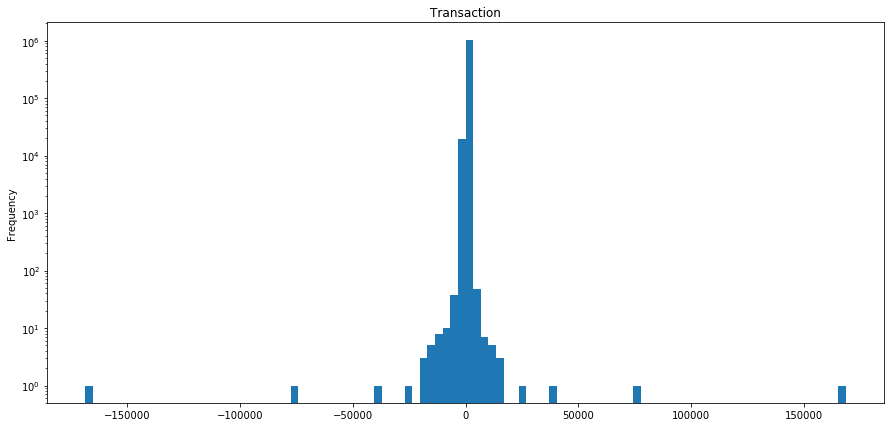

In [270]:
tit='Transaction'
df['Transaction'].plot(kind='hist',logy=True,title=tit,bins=100,figsize=(15,7))

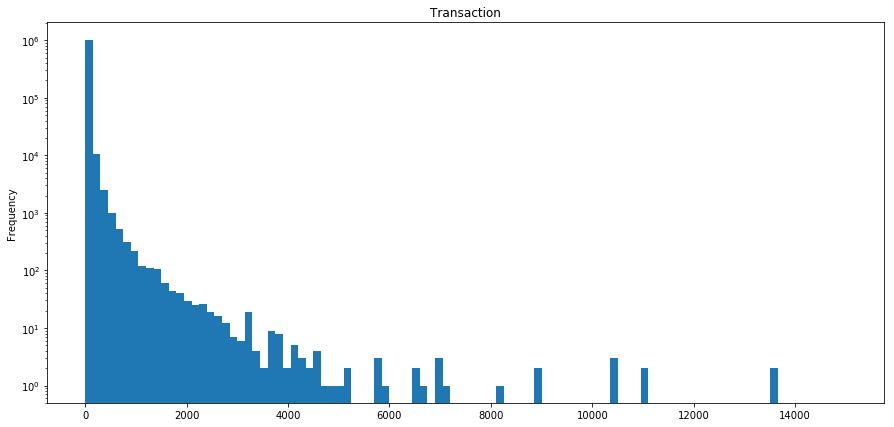

In [271]:
tit='Transaction'
df.loc[ (df.Transaction >0) ].Transaction.plot(kind='hist',logy=True,title=tit,bins=100,range=(0,15000),figsize=(15,7))

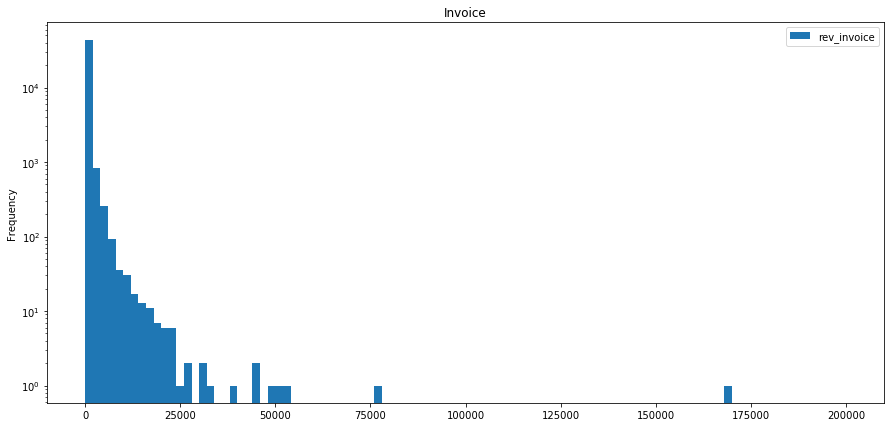

In [272]:
tit='Invoice'
df.groupby('Invoice').Transaction.agg([sum])    \
   .rename(columns={"sum": "rev_invoice"})            \
   .sort_values(by=['rev_invoice'],ascending=False)  \
   .plot(kind='hist',logy=True,title=tit,bins=100,range=(0,200000),figsize=(15,7))

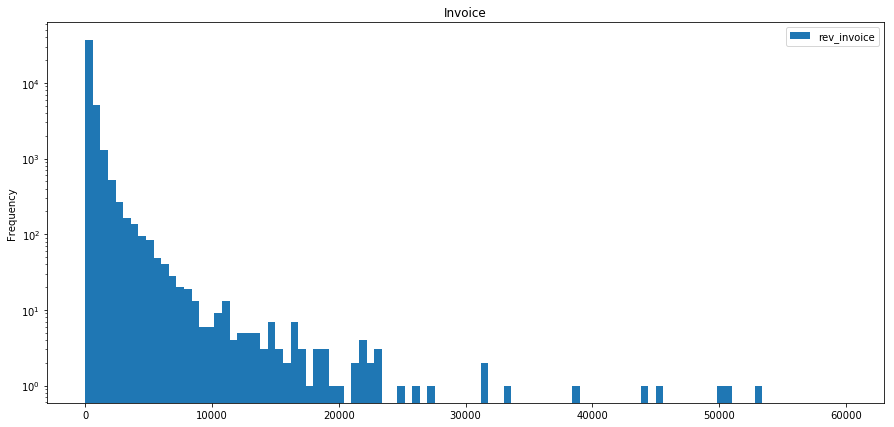

In [273]:
tit='Invoice'
df.groupby('Invoice').Transaction.agg([sum])    \
   .rename(columns={"sum": "rev_invoice"})            \
   .sort_values(by=['rev_invoice'],ascending=False)  \
   .plot(kind='hist',logy=True,title=tit,bins=100,range=(0,60000),figsize=(15,7))

In [274]:
print('There are %d unique customers'%len(df.Customer_ID.unique()))

There are 5943 unique customers


In [275]:
print('Customers are from %d countries'%len(df.Country.unique()))

Customers are from 43 countries


In [276]:
# I consider here only transactions with positive proceeds

transaction_plus   = (df.loc[df.Transaction > 0.]).Transaction.agg([sum])
transaction_cancel = (df.loc[df.Transaction < 0.]).Transaction.agg([sum])
print('The total cash intake is %e pounds,\n the total amount from cancellations is %e (%f )' \
        %(transaction_plus,transaction_cancel,-100*transaction_cancel/transaction_plus))

The total cash intake is 2.096191e+07 pounds,
 the total amount from cancellations is -1.527041e+06 (7.284841 )


In [277]:
# toggle between the whole dataset (df) and the transactions w/ Customer_ID=Nan 
# to check for biases
UU = df

Cust_vs_country = UU.groupby('Country').Customer_ID.unique().agg([len])     \
                    .rename(columns={"len": "num_customers"})               \
                    .sort_values(by=['num_customers'],ascending=False)

# I consider here only transactions with positive proceeds
# I'll make a dedicated plot/column here below for negative/cancelled goods
Revenue_vs_country = (UU.loc[UU.Transaction > 0.])                        \
                     .groupby('Country').Transaction.agg([sum])           \
                    .rename(columns={"sum": "revenue"})                     \
                    .sort_values(by=['revenue'],ascending=False)

Cancellation_vs_country = (UU.loc[UU.Transaction < 0.])                \
                          .groupby('Country').Transaction.agg([sum])    \
                          .rename(columns={"sum": "cancellation"})            \
                          .sort_values(by=['cancellation'],ascending=False)

# I chose to count ANY item listed, be it purchased or cancelled
Items_vs_country = UU.groupby('Country').Invoice.agg([len])    \
                    .rename(columns={"len": "num_items"})            \
                    .sort_values(by=['num_items'],ascending=False)

# I chose to count ANY item listed, be it purchased or cancelled
Invoices_vs_country = UU.groupby('Country').Invoice.unique().agg([len])    \
                    .rename(columns={"len": "num_invoices"})            \
                    .sort_values(by=['num_invoices'],ascending=False)

NoCustomerID_vs_country = df[df.isnull().any(axis=1)]                \
                    .groupby('Country').Transaction.agg([sum])     \
                    .rename(columns={"sum": "no_customer_id"})            \
                    .sort_values(by=['no_customer_id'],ascending=False) \

df_vs_country = Cust_vs_country              \
                .join(Revenue_vs_country )    \
                .join(Cancellation_vs_country)    \
                .join(Items_vs_country)   \
                .join(Invoices_vs_country)   \
                .join(NoCustomerID_vs_country,how='outer')   \
                .fillna(0)                                  \
                .sort_values(by=['revenue'],ascending=False) \

df_vs_country['rel_cancellation']   = \
           -100*df_vs_country['cancellation']/df_vs_country['revenue']

df_vs_country['rel_no_customer_id'] = \
            100*df_vs_country['no_customer_id']/df_vs_country['revenue']

In [278]:
NoCustomerID_vs_country

,no_customer_id
Country,
United Kingdom,2.723775e+06
EIRE,3.701792e+04
Hong Kong,1.403930e+04
Unspecified,2.310560e+03
France,1.687130e+03
Bahrain,1.507180e+03
RSA,1.435290e+03
Bermuda,1.253140e+03
Israel,9.135700e+02


In [279]:
df_vs_country

,num_customers,revenue,cancellation,num_items,num_invoices,no_customer_id,rel_cancellation,rel_no_customer_id
Country,,,,,,,,
United Kingdom,5411,1.786029e+07,-1330091.31,981324,49102,2.723775e+06,7.447199,15.250453
EIRE,6,6.644318e+05,-48912.23,17866,806,3.701792e+04,7.361513,5.571365
Netherlands,23,5.542323e+05,-5707.39,5140,250,0.000000e+00,1.029783,0.000000
Germany,107,4.312625e+05,-13273.90,17624,1095,0.000000e+00,3.077917,0.000000
France,96,3.569446e+05,-28752.80,14330,746,1.687130e+03,8.055256,0.472659
Australia,15,1.699681e+05,-2839.04,1913,117,0.000000e+00,1.670337,0.000000
Spain,41,1.091785e+05,-17319.05,3811,188,0.000000e+00,15.863055,0.000000
Switzerland,23,1.010113e+05,-1282.53,3189,123,6.459500e+02,1.269690,0.639483
Sweden,20,9.190372e+04,-4094.30,1364,129,3.540000e+02,4.454988,0.385186


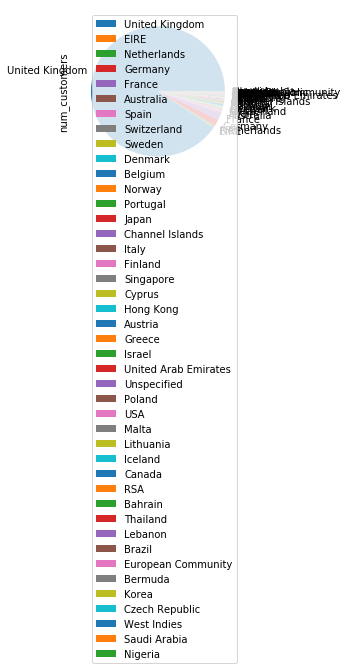

In [280]:
# https://www.w3resource.com/pandas/dataframe/dataframe-plot-bar.php
# good reference for plotting directly from pandas (less code!)
df_vs_country.plot.pie(y='num_customers', figsize=(3, 3))

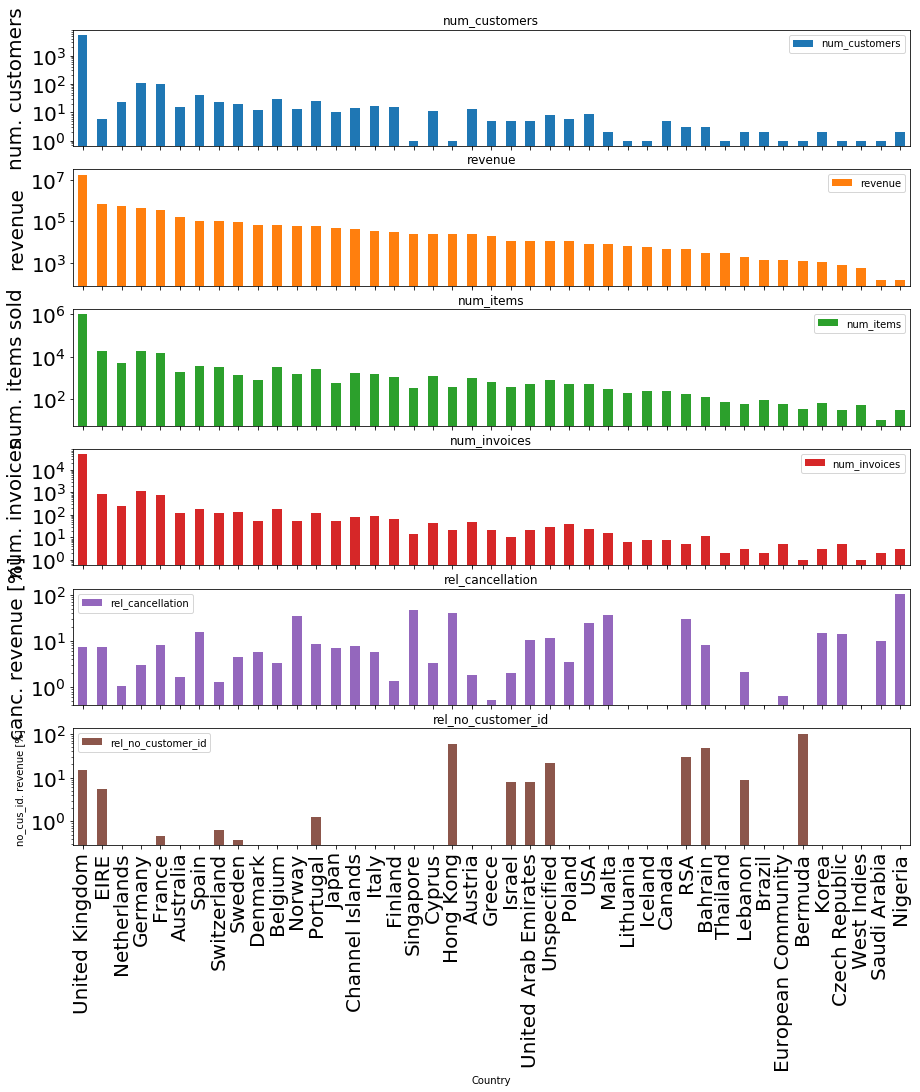

In [281]:
ax= df_vs_country.drop(['cancellation','no_customer_id'], axis=1)  \
    .plot.bar(rot=90,figsize=(15,15),logy=True,fontsize=20,subplots=True)

ax[0].set(ylabel = 'num. customers')
ax[1].set(ylabel = 'revenue')
ax[2].set(ylabel = 'num. items sold')
ax[3].set(ylabel = 'num. invoices')
ax[4].set(ylabel = 'canc. revenue [%]')
# ax[4].set_yscale('linear')
ax[5].set(ylabel = 'no_cus_id. revenue [%]')
#ax[5].set_yscale('linear')

for v in range(5):
    ax[v].yaxis.get_label().set_fontsize(20)

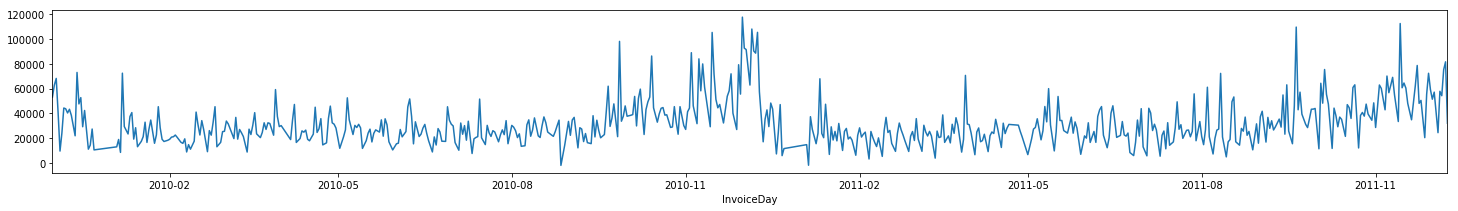

In [282]:
df.groupby('InvoiceDay').Transaction.agg(sum).plot(figsize=(25, 3))

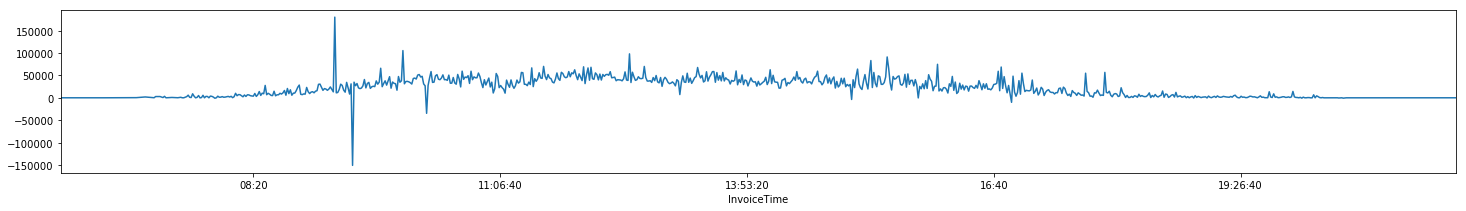

In [283]:
df.groupby('InvoiceTime').Transaction.agg(sum).plot(figsize=(25, 3))  # must be limited to >0

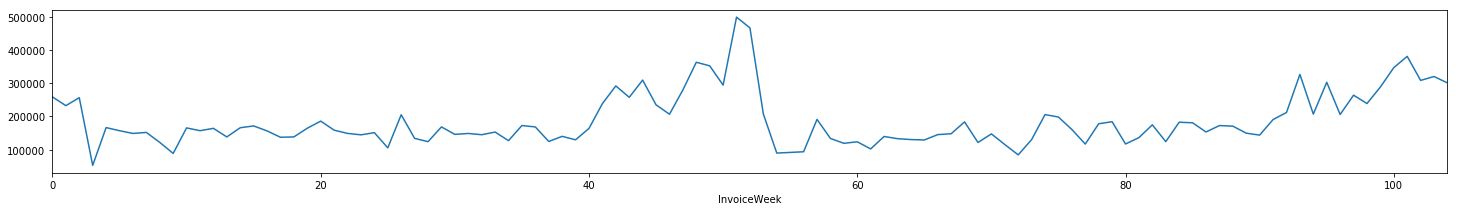

In [284]:
df.groupby('InvoiceWeek').Transaction.agg(sum).plot(figsize=(25, 3))

In [285]:
# the largest customer by total net revenue (i.e. taking into account also cancellations, in negative)
# is in the UK and has ID 18102.0 and has purchased for 600k pounds
df.groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                  \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Total Customer Revenue'],ascending=False).head(10)        

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
18102.0,598215.22,-3580.80,3884.00,1068.0
14646.0,523342.07,-947.08,4992.00,3890.0
14156.0,296564.69,-2736.16,2736.16,4130.0
14911.0,270248.53,-1687.17,1687.17,11613.0
17450.0,233579.39,-3825.36,7144.72,448.0
13694.0,190825.52,-864.00,952.00,1558.0
17511.0,171885.98,-185.30,1401.60,2134.0
12415.0,143269.29,-425.00,1718.40,990.0
16684.0,141502.25,-816.00,1836.00,749.0


In [286]:
# the customer with the largest number of transactions is 
# is in the UK, has ID 17841.0 and has carried out 13.1k transactions
df.groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                  \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Number of Transaction'],ascending=False).head(10)    

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
17841.0,69516.19,-88.50,349.50,13097.0
14911.0,270248.53,-1687.17,1687.17,11613.0
12748.0,49970.13,-1829.84,850.50,7307.0
14606.0,30094.38,-55.10,139.30,6709.0
14096.0,57120.91,-1100.44,1599.26,5128.0
15311.0,113513.07,-275.00,408.00,4717.0
14156.0,296564.69,-2736.16,2736.16,4130.0
14646.0,523342.07,-947.08,4992.00,3890.0
13089.0,113214.19,-1051.20,1051.20,3438.0


In [287]:
# the customer with the largest number of transactions is 
# is in the UK, has ID 17841.0 and has carried out 12.9 transactions (excluding cancellation transactions)
df.loc[df.Transaction>0]                                                                                      \
    .groupby('Customer_ID').Transaction.agg([sum,min,max,len])                                                \
        .rename(columns={'sum': 'Total Customer Revenue',                                                     \
                         'min': 'Min Transaction','max': 'Max Transaction',                                   \
                            'len' : 'Number of Transaction'})                                                 \
              .sort_values(by=['Number of Transaction'],ascending=False).head(10)    

,Total Customer Revenue,Min Transaction,Max Transaction,Number of Transaction
Customer_ID,,,,
17841.0,70884.07,0.19,349.50,12890.0
14911.0,295972.63,1.45,1687.17,11245.0
12748.0,56599.39,0.06,850.50,7228.0
14606.0,30861.06,0.12,139.30,6566.0
14096.0,65164.79,0.42,1599.26,5111.0
15311.0,116771.16,0.21,408.00,4434.0
14156.0,313946.37,1.25,2736.16,4048.0
14646.0,528602.52,0.39,4992.00,3849.0
13089.0,116737.86,1.68,1051.20,3362.0


In [288]:
# the UK generates the largest revenue (16M over the two years),
# surprisingly EIRE is the second largest source of revenue, with 0.6M (despite having only 6 customers, they must be huge customers)
df.groupby('Country').Transaction.sum().sort_values(ascending=False)

Country
United Kingdom          1.653020e+07
EIRE                    6.155196e+05
Netherlands             5.485250e+05
Germany                 4.179886e+05
France                  3.281918e+05
Australia               1.671291e+05
Switzerland             9.972876e+04
Spain                   9.185948e+04
Sweden                  8.780942e+04
Denmark                 6.574109e+04
Belgium                 6.357449e+04
Portugal                5.313680e+04
Japan                   4.377658e+04
Channel Islands         4.145361e+04
Norway                  3.924303e+04
Italy                   3.067935e+04
Finland                 2.951445e+04
Cyprus                  2.416274e+04
Austria                 2.317760e+04
Greece                  1.899549e+04
Hong Kong               1.403930e+04
Singapore               1.315816e+04
Israel                  1.110722e+04
Poland                  1.052809e+04
United Arab Emirates    9.948650e+03
Unspecified             9.687320e+03
Lithuania               6.5537

In [289]:
df.groupby('Country').Transaction.sum().sort_values(ascending=False)

Country
United Kingdom          1.653020e+07
EIRE                    6.155196e+05
Netherlands             5.485250e+05
Germany                 4.179886e+05
France                  3.281918e+05
Australia               1.671291e+05
Switzerland             9.972876e+04
Spain                   9.185948e+04
Sweden                  8.780942e+04
Denmark                 6.574109e+04
Belgium                 6.357449e+04
Portugal                5.313680e+04
Japan                   4.377658e+04
Channel Islands         4.145361e+04
Norway                  3.924303e+04
Italy                   3.067935e+04
Finland                 2.951445e+04
Cyprus                  2.416274e+04
Austria                 2.317760e+04
Greece                  1.899549e+04
Hong Kong               1.403930e+04
Singapore               1.315816e+04
Israel                  1.110722e+04
Poland                  1.052809e+04
United Arab Emirates    9.948650e+03
Unspecified             9.687320e+03
Lithuania               6.5537

In [290]:
df.groupby('Customer_ID').size().value_counts()

1       146
6        84
11       82
16       80
12       79
18       77
13       76
5        75
20       74
21       74
7        73
8        72
9        71
14       70
19       67
2        65
10       64
23       64
17       60
4        60
35       58
15       58
29       57
28       56
22       55
25       54
26       54
27       53
30       53
34       52
       ... 
658       1
662       1
694       1
718       1
730       1
750       1
478       1
462       1
1049      1
446       1
1069      1
1089      1
1109      1
1133      1
1241      1
1301      1
1353      1
1419      1
178       1
234       1
282       1
330       1
362       1
390       1
394       1
402       1
406       1
422       1
434       1
1885      1
Length: 701, dtype: int64

<a id='the_destination'></a>

[Pippo goes to the cinema](section-title)